# 📊 MiniProject 1: Getting Started with Machine Learning

**Course:** COMP 551 - Applied Machine Learning<br/>
**Institution:** McGill University  
**Group:** Giane Mayumi Galhard (51261276747), Daria Goptsii (261275056), Yixuan Qin (261010963)
**Term:** Fall 2025

---

This project aims to help us get started with programming for Machine Learning by implementing and analyzing Linear regression and Logistic regression on two distinct datasets.

---

## Setup

Importing libraries, packages and modules.

In [42]:
!pip install ucimlrepo

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Model implementation


### Linear regression


#### Analytical Linear Regression

In [44]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]                         #add a dimension for the features
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])    #add bias by adding a constant feature of value 1
        #alternatively: self.w = np.linalg.inv(x.T @ x)@x.T@y
        self.w = np.linalg.lstsq(x, y)[0]          #return w for the least square difference
        return self

    def predict(self, x):
        if self.add_bias:
            N = x.shape[0] #ADC
            x = np.column_stack([x,np.ones(N)])
        if x.ndim == 1: #ADC
            x = x[:, None]
        yh = x@self.w                             #predict the y values
        return yh

    def cost_fn(self, y, yh):
      if isinstance(y, pd.DataFrame):
        y = y.values
      return 0.5*np.mean((y - yh)**2)

#### Linear regression with optimizer

In [45]:
class LinearRegressionOptimizer:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass

    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):                          # define the gradient function
            w = w.reshape(-1, 1) # Reshape w to be a column vector
            y = y.reshape(-1, 1) # Reshape y to be a column vector
            yh =  x @ w
            grad = .5*np.dot((yh - y).T, x)/N # Adjust dot product for reshaped y and yh
            return grad.flatten() # Flatten the gradient before returning
        w0 = np.zeros(D)                                # initialize the weights to 0
        self.w = optimizer.run(gradient, x, y, w0)      # run the optimizer to get the optimal weights
        return self

    def predict(self, x):
        if x.ndim == 1: #ADC
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0] #AD
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        yh = x@self.w
        return yh

### Non-linear bases

In [46]:
#Gaussian basis
def gaussian_basis_fit(X, D=10, sigma='auto'):
    X = np.asarray(X)
    lo = X.min(axis=0)
    hi = X.max(axis=0)
    mus = np.stack([np.linspace(lo[j], hi[j], D) for j in range(X.shape[1])], axis=0)
    if sigma == 'auto':
        spac = np.where(D > 1, (mus[:,1]-mus[:,0]), np.maximum((hi-lo)/10.0, 1e-6))
        sig = np.maximum(spac, 1e-6)
    else:
        sig = np.full(X.shape[1], float(sigma))
    return mus, sig

# φ_{jd}(x_j) = exp( - ((x_j - μ_{jd}) / σ_j)^2 )
def gaussian_basis_transform(X, mus, sig):
    X = np.asarray(X)
    Z = []
    for j in range(X.shape[1]):
        Z.append(np.exp(-((X[:, [j]] - mus[j][None, :]) / sig[j]) ** 2))
    return np.concatenate(Z, axis=1)

# Sigmoid basis
def sigmoid_basis_fit(X, D=10, s='auto'):
    X = np.asarray(X)
    lo = X.min(axis=0)
    hi = X.max(axis=0)
    mus = np.stack([np.linspace(lo[j], hi[j], D) for j in range(X.shape[1])], axis=0)  # (p, D)
    if s == 'auto':
        spac = np.where(D > 1, (mus[:,1]-mus[:,0]), np.maximum((hi-lo)/10.0, 1e-6))
        sc = np.maximum(spac, 1e-6)
    else:
        sc = np.full(X.shape[1], float(s))
    return mus, sc

#φ_{jd}(x_j) = 1 / (1 + exp(-(x_j - μ_{jd}) / s_j))
def sigmoid_basis_transform(X, mus, sc):
    X = np.asarray(X)
    Z = []
    for j in range(X.shape[1]):
        Z.append(1.0 / (1.0 + np.exp(-(X[:, [j]] - mus[j][None, :]) / sc[j])))
    return np.concatenate(Z, axis=1)


### Logistic regression

In [47]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e4, verbose=False):
      self.add_bias = add_bias
      self.learning_rate = learning_rate
      self.epsilon = epsilon                        #to get the tolerance for the norm of gradients
      self.max_iters = max_iters                    #maximum number of iteration of gradient descent
      self.verbose = verbose

    def fit(self, x, y):
      if x.ndim == 1:
        x = x[:, None]
      if self.add_bias:
        N = x.shape[0]
        x = np.column_stack([x,np.ones(N)])
      N,D = x.shape
      self.w = np.zeros(D)
      g = np.inf
      t = 0
      # the code snippet below is for gradient descent
      while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
        g = self.gradient(x, y)
        self.w = self.w - self.learning_rate * g
        t += 1

      if self.verbose:
        print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
        print(f'the weight found: {self.w}')
      return self

    def predict(self, x):
      if x.ndim == 1:
        x = x[:, None]
      Nt = x.shape[0]
      if self.add_bias:
        x = np.column_stack([x,np.ones(Nt)])
      yh = logistic(np.dot(x,self.w))            #predict output
      return yh

    def gradient(self, x, y):
      N,D = x.shape
      yh = logistic(np.dot(x, self.w))    # predictions  size N
      grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
      return grad

    def cost_fn(self, y, yh):
      eps = 1e-12   # avoid log(0)
      yh = np.clip(yh, eps, 1 - eps)
      J = -np.mean(y * np.log(yh) + (1 - y) * np.log(1 - yh))
      return J

### Gradient descent

##### Vanilla Gradient Descent

In [48]:
class GradientDescent:

    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)               # compute the gradient with present weight
            self.w_history.append(w)
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w


#### Mini-Batch SGD

In [49]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

class Minibatch_SGD:
  def __init__(self, add_bias=True, model="Linear", learning_rate=0.1):
    self.add_bias = add_bias
    self.w = None
    self.model = model
    self.learning_rate = learning_rate
    pass

  def predict(self, X, w):
    if self.model == "Linear":
      return np.dot(X, w)
    elif self.model == "Logistic":
      return logistic(np.dot(X, w))

  def gradient(self, X, y, w):
    N,D = X.shape
    yh = np.dot(X, w)
    grad = np.dot(X.T, yh - y)/N           # divide by N because cost is mean over N points
    return grad

  def cost_fn(self, X, y, w):
    if isinstance(y, pd.DataFrame):
      y = y.values
    yh = self.predict(X, w)

    if self.model == "Linear":
      return 0.5*np.mean((y - yh)**2)
    elif self.model == "Logistic":
      eps = 1e-12
      yh = np.clip(yh, eps, 1 - eps)
      return -np.mean(y * np.log(yh) + (1 - y) * np.log(1 - yh))

  def create_mini_batches(self, X, y, batch_size):
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    data = np.hstack((X, y))
    np.random.shuffle(data)
    mini_batches = []
    N = data.shape[0]
    n_minibatches = N // batch_size
    for i in range(n_minibatches):
        mini_batch = data[i*batch_size:(i+1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        y_mini = mini_batch[:, -1].reshape(-1,1)
        mini_batches.append((X_mini, y_mini))
    if N % batch_size != 0:
        mini_batch = data[n_minibatches*batch_size:, :]
        X_mini = mini_batch[:, :-1]
        y_mini = mini_batch[:, -1].reshape(-1,1)
        mini_batches.append((X_mini, y_mini))
    return mini_batches

  # Mini-batch gradient descent
  def fit(self, X, y, batch_size=32, max_iters=10, add_bias=True):
      X = np.array(X)
      y = np.array(y).reshape(-1, 1)

      # Add bias column if requested
      if add_bias:
          X = np.hstack([X, np.ones((X.shape[0], 1))])

      # Initialize parameters (bias + coefficients if bias added)
      w = np.zeros((X.shape[1], 1))

      error_list = []

      for itr in range(max_iters):
          mini_batches = self.create_mini_batches(X, y, batch_size)
          for X_mini, y_mini in mini_batches:
              w = w - self.learning_rate * self.gradient(X_mini, y_mini, w)
              error_list.append(self.cost_fn(X_mini, y_mini, w))
      self.w = w
      return w, error_list

### Metrics

In [50]:
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MSE":  float(mse),
        "RMSE": float(np.sqrt(mse)),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2":  float(r2_score(y_true, y_pred)),
    }


def f_scores_univariate(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()
    n = X.shape[0]
    Xc = X - X.mean(axis=0, keepdims=True)
    yc = y - y.mean()
    num = (Xc * yc[:, None]).sum(axis=0)
    den = np.sqrt((Xc**2).sum(axis=0) * (yc**2).sum())
    r = np.where(den > 0, num / den, 0.0)
    eps = 1e-12
    F = (r**2) * ((n - 2) / np.maximum(1.0 - r**2, eps))
    return F

def select_k_best_indices(X, y, k):
    scores = f_scores_univariate(X, y)
    idx = np.argsort(scores)[::-1][:k]
    return idx, scores

## Data importing and cleaning

### Parkinson’s Motor Scores

**Data Cleaning and Preprocessing**

*   The raw data contains patient identifiers and time indices, which are not predictive and were therefore removed.
*   Handled missing values and non-numeric entries by replacing common placeholders ("?", "NA", "nan", etc.) with NaN and coercing all feature columns into numeric types.
*   Removed incomplete rows for feature-target alignment.
*   Target selection: kept motor_UPDRS and dropped total_UPDRS for this regression task.

**Note:** some examples of import code on the dataset website page imports total_UPDRS into the target matrix, not the feature matrix. While adding it as a feature significantly improves accuracy, this is misleading as it is strongly correlated with motor_UPDRS (the true target) and creates target leakage. Using it would artificially imrpove performance without reflecting real predictive ability, therefore we did not include it in our feature matrix.


In [51]:
parkinsons_telemonitoring = fetch_ucirepo(id=189)

X_raw_P = parkinsons_telemonitoring.data.features.copy()
y_raw_P = parkinsons_telemonitoring.data.targets.copy()

cols_to_drop = [c for c in ["subject#", "test_time"] if c in X_raw_P.columns]
X_df_P = X_raw_P.drop(columns=cols_to_drop)

X_df_P = X_df_P.replace(["?", "NA", "na", "NaN", "nan", ""], np.nan)
for c in X_df_P.columns:
    if X_df_P[c].dtype == "object":
        X_df_P[c] = pd.to_numeric(X_df_P[c], errors="coerce")

X_df_P = X_df_P.dropna()
y_df_P = y_raw_P.loc[X_df_P.index]
y_df_P = y_df_P.drop(columns=["total_UPDRS"])

print("Cleaned X_df shape:", X_df_P.shape)
print("Aligned y_series shape:", y_raw_P.shape)


Cleaned X_df shape: (5875, 18)
Aligned y_series shape: (5875, 2)


Although removing highly correlated features is generally considered good practice in linear regression, our further experiments showed that dropping additional features did not improve performance.

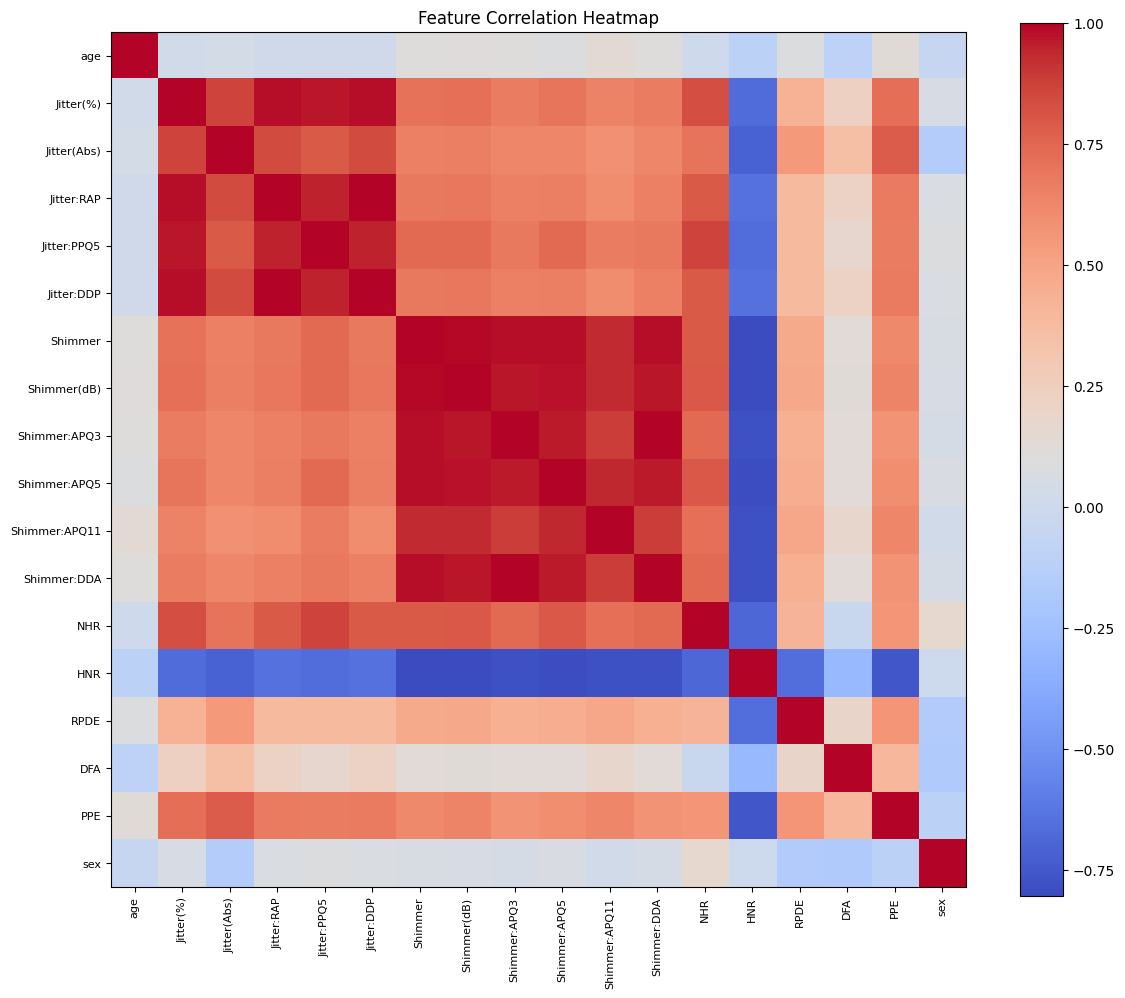

In [52]:
corr = pd.DataFrame(X_df_P).corr()

plt.figure(figsize=(12, 10))
im = plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(im)
plt.title("Feature Correlation Heatmap")

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.index)), corr.index, fontsize=8)

plt.tight_layout()
plt.show()

Most voice features such as Jitter (all variants), Shimmer (all variants), NHR, and PPE are positively skewed, with most values near zero but long right tails caused by outliers. Features like HNR, RPDE, DFA, and age are closer to symmetric. The target motor_UPDRS ranges from about 5 to 40, the distribution is right-skewed.

Target summary (motor_UPDRS):


,motor_UPDRS
count,5875.000000
mean,21.296229
std,8.129282
min,5.037700
5%,8.467100
25%,15.000000
50%,20.871000
75%,27.596500
95%,35.034600
max,39.511000



Feature summary:


,count,mean,std,min,25%,50%,75%,max
age,5875.0,64.804936,8.821524,36.000000,58.000000,65.000000,72.000000,85.000000
Jitter(%),5875.0,0.006154,0.005624,0.000830,0.003580,0.004900,0.006800,0.099990
Jitter(Abs),5875.0,0.000044,0.000036,0.000002,0.000022,0.000034,0.000053,0.000446
Jitter:RAP,5875.0,0.002987,0.003124,0.000330,0.001580,0.002250,0.003290,0.057540
Jitter:PPQ5,5875.0,0.003277,0.003732,0.000430,0.001820,0.002490,0.003460,0.069560
Jitter:DDP,5875.0,0.008962,0.009371,0.000980,0.004730,0.006750,0.009870,0.172630
Shimmer,5875.0,0.034035,0.025835,0.003060,0.019120,0.027510,0.039750,0.268630
Shimmer(dB),5875.0,0.310960,0.230254,0.026000,0.175000,0.253000,0.365000,2.107000
Shimmer:APQ3,5875.0,0.017156,0.013237,0.001610,0.009280,0.013700,0.020575,0.162670
Shimmer:APQ5,5875.0,0.020144,0.016664,0.001940,0.010790,0.015940,0.023755,0.167020


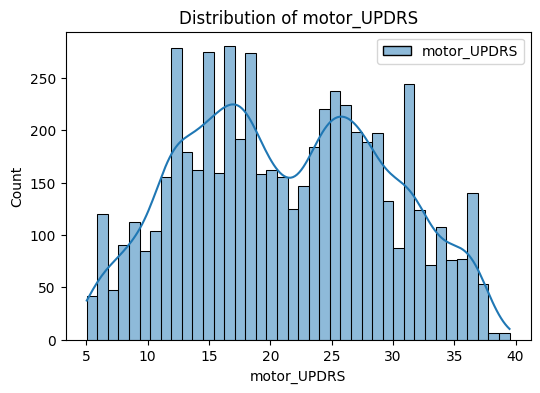

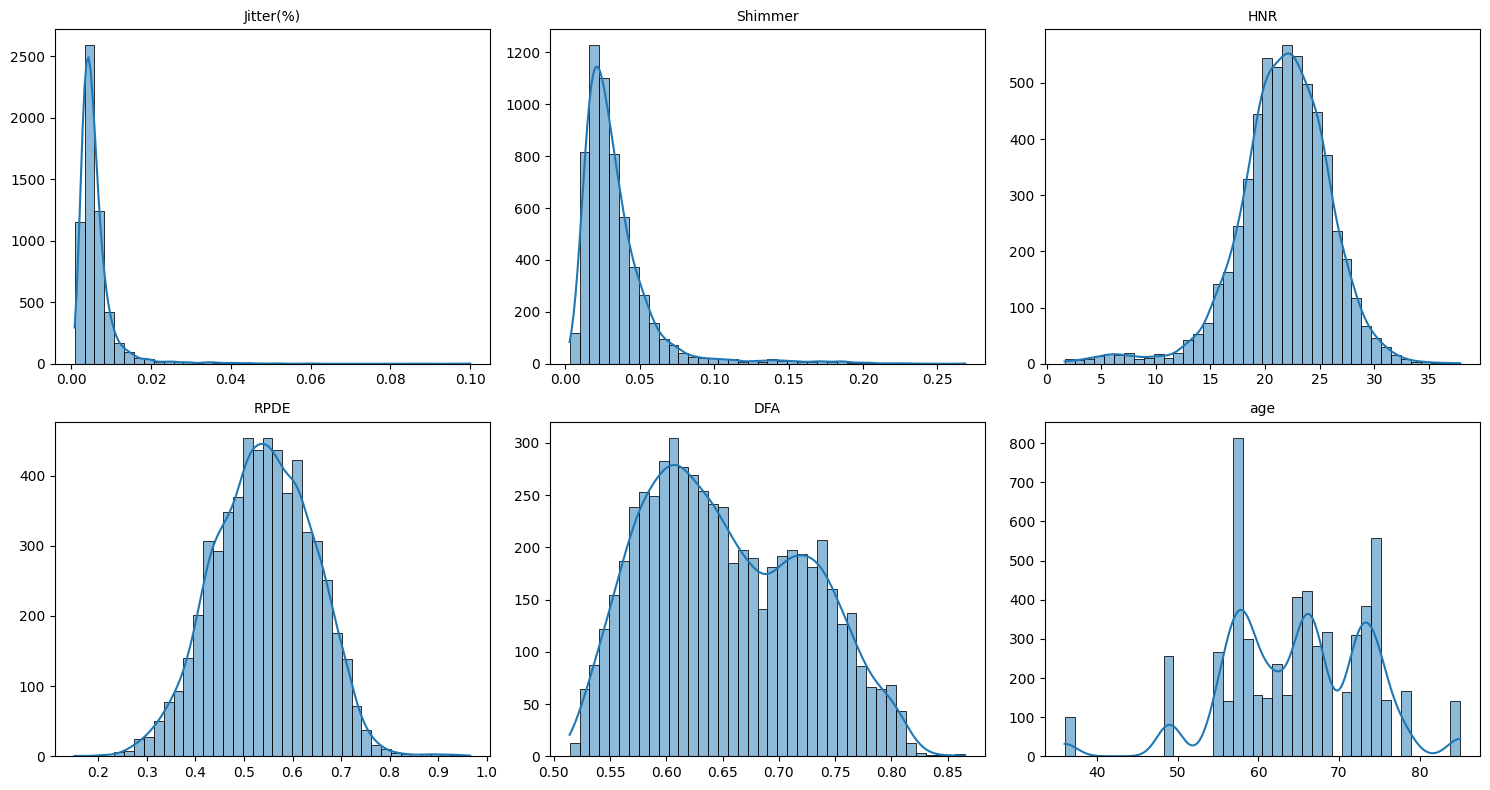

In [53]:
print("Target summary (motor_UPDRS):")
display(y_df_P.describe(percentiles=[0.05,0.25,0.5,0.75,0.95]))

print("\nFeature summary:")
display(X_df_P.describe().T)  # first 10 features as preview

plt.figure(figsize=(6,4))
sns.histplot(y_df_P, bins=40, kde=True)
plt.title("Distribution of motor_UPDRS")
plt.xlabel("motor_UPDRS")
plt.ylabel("Count")
plt.show()

selected = ["Jitter(%)", "Shimmer", "HNR", "RPDE", "DFA", "age"]

n_cols = 3
n_rows = int(np.ceil(len(selected) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(selected):
    if col in X_df_P.columns:
        sns.histplot(X_df_P[col], bins=40, kde=True, ax=axes[i])
        axes[i].set_title(f"{col}", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
    else:
        axes[i].axis("off")

plt.tight_layout()
plt.show()


Preprocessing pipeline: numeric features were were scaled using z-score scaling (mean ≈ 0, std ≈ 1) and binary features ("age") one-hot encoded. IQR rule was applied to detect and remove outliers from the numeric features.

In [54]:
binary_cols_P = [c for c in X_df_P.columns if X_df_P[c].nunique(dropna=True) == 2]
numeric_cols_P = [c for c in X_df_P.columns if c not in binary_cols_P]

print("Binary (OHE) columns:", binary_cols_P)
print("Numeric (scaled) columns:", numeric_cols_P)
def remove_outliers_iqr(df, cols, y=None, k=1.5):
    mask = pd.Series([True] * len(df), index=df.index)
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        mask &= df[col].between(lower, upper, inclusive="both")
    if y is not None:
        return df.loc[mask], y.loc[mask]
    return df.loc[mask]

X_no_outliers_P, y_no_outliers_P = remove_outliers_iqr(X_df_P, numeric_cols_P, y_df_P, k=1.5)

print("Original shape:", X_df_P.shape)
print("After outlier removal:", X_no_outliers_P.shape)


Binary (OHE) columns: ['sex']
Numeric (scaled) columns: ['age', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']
Original shape: (5875, 18)
After outlier removal: (4944, 18)


In [55]:

preprocessor_P = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_P),
        ("bin", OneHotEncoder(
            sparse_output=False,
            handle_unknown="ignore",
            drop=None
        ), binary_cols_P),
    ],
    remainder="drop",
)

preprocessor_P.fit(X_no_outliers_P)

X_scaled_all = preprocessor_P.transform(X_no_outliers_P)

num_features_P = numeric_cols_P
bin_features_P = preprocessor_P.named_transformers_["bin"].get_feature_names_out(binary_cols_P)
all_features_P = list(num_features_P) + list(bin_features_P)
X_scaled_all_df = pd.DataFrame(X_scaled_all, columns=all_features_P, index=X_no_outliers_P.index)

print("\nScaled numeric summary (entire dataset):")
display(X_scaled_all_df[numeric_cols_P].describe().T[["mean", "std", "min", "max"]])


Scaled numeric summary (entire dataset):


,mean,std,min,max
age,-6.093651e-16,1.000101,-2.022753,2.441420
Jitter(%),-6.898473e-17,1.000101,-1.932412,3.499404
Jitter(Abs),-2.529440e-16,1.000101,-1.672811,3.482373
Jitter:RAP,-1.149746e-16,1.000101,-1.796222,3.534241
Jitter:PPQ5,1.264720e-16,1.000101,-1.875881,3.425070
Jitter:DDP,-2.069542e-16,1.000101,-1.799675,3.534376
Shimmer,4.598982e-17,1.000101,-2.014731,3.459203
Shimmer(dB),-2.414466e-16,1.000101,-2.049903,3.524158
Shimmer:APQ3,9.772837e-17,1.000101,-1.798222,3.364174
Shimmer:APQ5,-3.219287e-16,1.000101,-1.847751,3.441909


### Breast Cancer Prediction

**Data Cleaning and Preprocessing**

*   The raw data contains patient identifiers was removed.
*   Handled missing values and non-numeric entries by replacing common placeholders ("?", "NA", "nan", etc.) with NaN and coercing all feature columns into numeric types.
*   Removed incomplete rows for feature-target alignment.
*   Categorical labels were mapped to numeric values (malignant = 1, benign = 0).


In [56]:
bc = fetch_ucirepo(id=17)   # Breast Cancer dataset
X_raw_B = bc.data.features.copy()
y_raw_B = bc.data.targets.copy()

# Drop ID column if present
cols_to_drop_B = [c for c in ["id", "ID", "patient_id", "sample_code_number"] if c in X_raw_B.columns]
X_df_B = X_raw_B.drop(columns=cols_to_drop_B)

# Replace missing markers, coerce to numeric when possible
X_df_B = X_df_B.replace(["?", "NA", "na", "NaN", "nan", ""], np.nan)
for c in X_df_B.columns:
    if X_df_B[c].dtype == "object":
        X_df_B[c] = pd.to_numeric(X_df_B[c], errors="coerce")

X_df_B = X_df_B.dropna()

y_df_B = y_raw_B.loc[X_df_B.index].copy()
if isinstance(y_df_B, pd.DataFrame) and y_df_B.shape[1] == 1:
    y_df_B = y_df_B.iloc[:, 0]


print("Cleaned X_df shape:", X_df_B.shape)
print("Aligned y_series shape:", y_df_B.shape)

Cleaned X_df shape: (569, 30)
Aligned y_series shape: (569,)


=== Class distribution ===
Diagnosis
B    357
M    212
Name: count, dtype: int64


/tmp/ipython-input-692308135.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_df_B.value_counts().index,


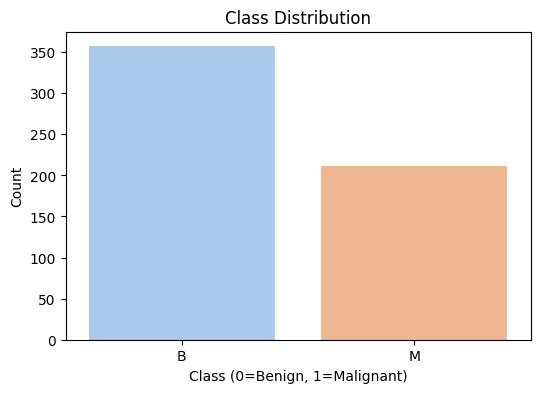


=== Summary statistics for selected features ===
                          mean         std        min         max
texture1             19.289649    4.301036    9.71000    39.28000
fractal_dimension1    0.062798    0.007060    0.04996     0.09744
radius2               0.405172    0.277313    0.11150     2.87300
concavity2            0.031894    0.030186    0.00000     0.39600
area3               880.583128  569.356993  185.20000  4254.00000
smoothness3           0.132369    0.022832    0.07117     0.22260


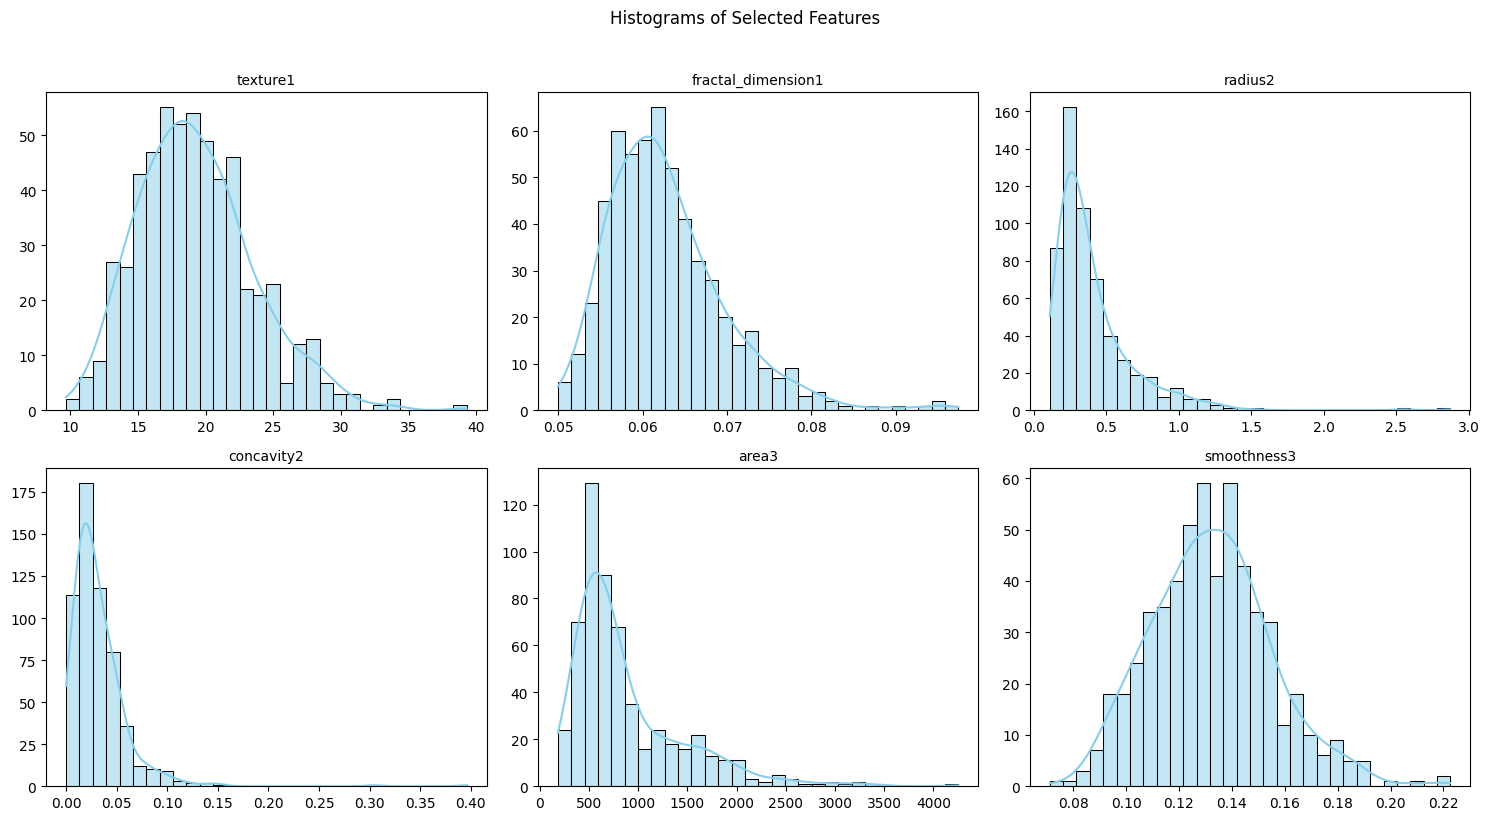

In [57]:
print("=== Class distribution ===")
print(y_df_B.value_counts())

plt.figure(figsize=(6,4))
sns.barplot(x=y_df_B.value_counts().index,
            y=y_df_B.value_counts().values,
            palette="pastel")
plt.title("Class Distribution")
plt.xlabel("Class (0=Benign, 1=Malignant)")
plt.ylabel("Count")
plt.show()

interesting_features = [
    "texture1",             # mean (different type)
    "fractal_dimension1",   # mean (small scale)
    "radius2",              # standard error (se)
    "concavity2",           # standard error (se, medium scale)
    "area3",                # worst (very large scale)
    "smoothness3"           # worst (small scale)
]

print("\n=== Summary statistics for selected features ===")
summary = X_df_B[interesting_features].describe().T
print(summary[["mean", "std", "min", "max"]])


n_cols = 3
n_rows = int(np.ceil(len(interesting_features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(interesting_features):
    if col in X_df_B.columns:
        sns.histplot(X_df_B[col], bins=30, kde=True, ax=axes[i], color="skyblue")
        axes[i].set_title(f"{col}", fontsize=10)
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")
    else:
        axes[i].axis("off")

plt.suptitle("Histograms of Selected Features", y=1.02)
plt.tight_layout()
plt.show()


The dataset contains 569 samples, with 357 benign and 212 malignant cases. Feature matrix includes a mix of large-scale variables (e.g., area-based measures) and small-scale descriptors (e.g., fractal dimension). Therefore scaring is a crucial step before modeling. Many features show right-skewed distributions, especially area and radius-based measures.

In [58]:
if y_df_B.dtype == object or str(y_df_B.dtype).startswith("string"):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_df_B.astype(str).values)
else:
    uniq_vals = np.sort(pd.unique(y_df_B))
    mapping = {uniq_vals[0]: 0, uniq_vals[1]: 1}
    y_encoded = y_df_B.map(mapping).astype(int).values

print("Target classes encoded to:", np.unique(y_encoded))

Target classes encoded to: [0 1]


In [59]:
numeric_cols_B = X_df_B.select_dtypes(include=[np.number]).columns.tolist()
binary_cols_B = [c for c in X_df_B.columns if c not in numeric_cols_B]
print("Binary (OHE) columns:", binary_cols_B)
print("Numeric (scaled) columns:", numeric_cols_B)
preprocessor_B = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols_B),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), binary_cols_B),
    ],
    remainder="drop",
)

X_all_B = preprocessor_B.fit_transform(X_df_B)

X_all_df_B = pd.DataFrame(
    X_all_B,
    index=X_df_B.index,
    columns=preprocessor_B.get_feature_names_out()
)

print("Transformed X shape:", X_all_df_B.shape)

Binary (OHE) columns: []
Numeric (scaled) columns: ['radius1', 'texture1', 'perimeter1', 'area1', 'smoothness1', 'compactness1', 'concavity1', 'concave_points1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'perimeter2', 'area2', 'smoothness2', 'compactness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'radius3', 'texture3', 'perimeter3', 'area3', 'smoothness3', 'compactness3', 'concavity3', 'concave_points3', 'symmetry3', 'fractal_dimension3']
Transformed X shape: (569, 30)


## Experiments

Clean data after scaling and dropping outliers

In [60]:
#PARKINSON

X_clean_P = X_scaled_all_df.copy()
y_clean_P= y_no_outliers_P.copy()


#BREAST CANCER

X_clean_B = X_all_df_B.copy()
y_clean_B= y_encoded.copy()

### Q1
Report the performance of linear regression and fully batched logistic regression. For both datasets use a 80/20
train/test split and report the performance on both training set and test set.

#### Linear regression
Results:

Removing outliers and scaling reduced RMSE from 7.5 to 7.37. However, metrics still leave much to be desired and further data preprocessing should be explored.



In [61]:
#BASELINE
X_train_P_base, X_test_P_base, y_train_P_base, y_test_P_base = train_test_split(
    X_df_P, y_df_P, test_size=0.20, random_state=42
)

Parkinson_lr_base = LinearRegression(add_bias=True).fit(X_train_P_base, y_train_P_base)
y_pred_base = Parkinson_lr_base.predict(X_test_P_base)

m_base = eval_metrics(y_test_P_base, y_pred_base)

In [62]:

X_train_tr_P, X_test_tr_P, y_train_tr_P, y_test_tr_P = train_test_split(
    X_clean_P, y_clean_P, test_size=0.20, random_state=42
)

Parkinson_lr = LinearRegression(add_bias=True).fit(X_train_tr_P, y_train_tr_P)

y_pred_train_my = Parkinson_lr.predict(X_train_tr_P)
y_pred_test_my  = Parkinson_lr.predict(X_test_tr_P)

m_train_my = eval_metrics(y_train_tr_P, y_pred_train_my)
m_test_my  = eval_metrics(y_test_tr_P,  y_pred_test_my)

y_pred_train_base = Parkinson_lr_base.predict(X_train_P_base)
y_pred_test_base  = Parkinson_lr_base.predict(X_test_P_base)

m_train_base = eval_metrics(y_train_P_base, y_pred_train_base)
m_test_base  = eval_metrics(y_test_P_base,  y_pred_test_base)

results = pd.DataFrame(
    [m_train_my, m_test_my, m_train_base, m_test_base],
    index=[
        "Scaled+OHE (Train)", "Scaled+OHE (Test)",
        "Baseline (Train)",  "Baseline (Test)"
    ]
).round(4)

print("\n=== Train/Test metrics ===")
print(results)




=== Train/Test metrics ===
                        MSE    RMSE     MAE      R2
Scaled+OHE (Train)  56.0566  7.4871  6.3549  0.1711
Scaled+OHE (Test)   54.3581  7.3728  6.2708  0.1609
Baseline (Train)    56.0966  7.4898  6.3080  0.1581
Baseline (Test)     56.3915  7.5094  6.3654  0.1165


#### Logistic regression

In [63]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_clean_B, y_clean_B, test_size=0.20, random_state=42, stratify=y_clean_B
)

model = LogisticRegression(add_bias=True, learning_rate=0.1, epsilon=1e-6, max_iters=10000, verbose=True)

yh_train_prob = model.fit(X_train_B, y_train_B).predict(X_train_B)
yh_test_prob  = model.predict(X_test_B)

# Convert probs -> class labels at 0.5 threshold
yh_train_cls = (yh_train_prob >= 0.5).astype(int)
yh_test_cls  = (yh_test_prob  >= 0.5).astype(int)

m_train_B = eval_metrics(y_train_B, yh_train_cls)
m_test_B  = eval_metrics(y_test_B,  yh_test_cls)

results_B = pd.DataFrame(
    [m_train_B, m_test_B],
    index=["Train Logistic", "Test Logistic"]
).round(4)

print("\n=== Train/Test metrics ===")
print(results_B)


terminated after 10000 iterations, with norm of the gradient equal to 0.002903917044874634
the weight found: [ 0.17600215  0.50241684  0.16675838  0.40043017  0.54266461 -1.21243013
  1.19935636  1.5520144  -0.52811044  0.22314319  2.36623794 -0.85739482
  1.32516273  1.70642678  0.4698736  -1.76514852 -0.23060988  1.00788148
 -0.75972464 -1.02317798  1.30307527  2.39372008  0.93661606  1.40655108
  0.38234142 -0.5424532   1.56490797  1.09039525  1.82654558  0.1385477
 -0.08156325]

=== Train/Test metrics ===
                   MSE    RMSE     MAE      R2
Train Logistic  0.0088  0.0938  0.0088  0.9624
Test Logistic   0.0263  0.1622  0.0263  0.8869


Unified Performance Table

In [64]:
# --- Recompute metrics cleanly ---

# Linear Regression (Scaled+OHE)
y_pred_train_my = Parkinson_lr.predict(X_train_tr_P)
y_pred_test_my  = Parkinson_lr.predict(X_test_tr_P)
m_my_train = eval_metrics(y_train_tr_P, y_pred_train_my)
m_my_test  = eval_metrics(y_test_tr_P,  y_pred_test_my)

# Linear Regression (Baseline)
y_pred_train_base = Parkinson_lr_base.predict(X_train_P_base)
y_pred_test_base  = Parkinson_lr_base.predict(X_test_P_base)
m_base_train = eval_metrics(y_train_P_base, y_pred_train_base)
m_base       = eval_metrics(y_test_P_base,  y_pred_test_base)

# --- Collect results ---
rows = [
    ("Linear Regression",  "Train", "Baseline",                        m_base_train),
    ("Linear Regression",  "Test",  "Baseline",                        m_base),
    ("Linear Regression",  "Train", "Outliers removed, scaled+OHE",    m_my_train),
    ("Linear Regression",  "Test",  "Outliers removed, scaled+OHE",    m_my_test),
    ("Logistic Regression","Train", "Fully batched",                   m_train_B),
    ("Logistic Regression","Test",  "Fully batched",                   m_test_B),
]

# --- Build MultiIndex DataFrame ---
index = pd.MultiIndex.from_tuples(
    [(model, split, variant) for model, split, variant, _ in rows],
    names=["Model", "Split", "Variant"]
)

all_metrics_df = pd.DataFrame([m for *_, m in rows], index=index).round(4)

print("\n=== Unified Performance Table (80/20 split) ===")
print(all_metrics_df.to_string())



=== Unified Performance Table (80/20 split) ===
                                                            MSE    RMSE     MAE      R2
Model               Split Variant                                                      
Linear Regression   Train Baseline                      56.0966  7.4898  6.3080  0.1581
                    Test  Baseline                      56.3915  7.5094  6.3654  0.1165
                    Train Outliers removed, scaled+OHE  56.0566  7.4871  6.3549  0.1711
                    Test  Outliers removed, scaled+OHE  54.3581  7.3728  6.2708  0.1609
Logistic Regression Train Fully batched                  0.0088  0.0938  0.0088  0.9624
                    Test  Fully batched                  0.0263  0.1622  0.0263  0.8869


### Q2
Report the weights of each of features in your trained models and discuss how each feature could affect the
performance of the models.

#### Linear regression

Results:
The largest weights were assigned to Shimmer: APQ3, Shimmer:DDA, Jitter:RAP, Jitter:DDP.

Interesting to observe that Shimmer: APQ3 and Shimmer:DDA, Jitter:RAP and Jitter:DDP have opposite signs.

Although these features describe similar aspects of voice irregularity, the model assignes them conflicting direction of influence. This suggests that linear models alone will not provide good results, however using non-linear feature transformations may improve results.

In [65]:

num_features_P = list(numeric_cols_P)
bin_features_P = list(preprocessor_P.named_transformers_["bin"].get_feature_names_out(binary_cols_P)) if binary_cols_P else []
all_features_P = num_features_P + bin_features_P

coefs = np.ravel(Parkinson_lr.w[:-1] if getattr(Parkinson_lr, "add_bias", False) else Parkinson_lr.w)

weights_df = pd.DataFrame({"Feature": all_features_P, "Weight": coefs})
weights_df["AbsWeight"] = weights_df["Weight"].abs()
weights_df = weights_df.sort_values("AbsWeight", ascending=False).reset_index(drop=True)

display(weights_df)



,Feature,Weight,AbsWeight
0,Shimmer:APQ3,-81.493469,81.493469
1,Shimmer:DDA,79.912731,79.912731
2,Jitter:RAP,-47.981371,47.981371
3,Jitter:DDP,47.820913,47.820913
4,sex_0,8.171022,8.171022
5,sex_1,5.686102,5.686102
6,Jitter(Abs),-4.264630,4.264630
7,Shimmer:APQ5,-2.969699,2.969699
8,Jitter(%),2.666373,2.666373
9,Shimmer:APQ11,2.354836,2.354836


The test of selecting k-best features based on the F-score shows that reducing the set of features does not improve performance.

In [66]:

baseline_mdl = LinearRegression(add_bias=True).fit(X_train_tr_P, y_train_tr_P)
y_pred_base  = baseline_mdl.predict(X_test_tr_P)
metrics_base = eval_metrics(y_test_tr_P, y_pred_base)
print("=== Baseline (all features, no selection) ===")
print({k: round(v, 4) for k, v in metrics_base.items()})

Xtr_full = np.asarray(X_train_tr_P)
Xte_full = np.asarray(X_test_tr_P)
ytr = np.asarray(y_train_tr_P).ravel()
yte = np.asarray(y_test_tr_P).ravel()

n_feats = Xtr_full.shape[1]
k_candidates = list(range(1, n_feats + 1))

results = []
preds = {}
best = {"k": None, "metrics": None, "y_pred": None, "idx": None, "model": None}

for k in k_candidates:
    idx_k, _ = select_k_best_indices(Xtr_full, ytr, k)
    Xtr_k = Xtr_full[:, idx_k]
    Xte_k = Xte_full[:, idx_k]

    mdl = LinearRegression(add_bias=True).fit(Xtr_k, ytr)
    y_pred = mdl.predict(Xte_k)
    metrics = eval_metrics(yte, y_pred)

    results.append((k, metrics))
    preds[k] = y_pred

    if best["metrics"] is None or metrics["MSE"] < best["metrics"]["MSE"]:
        best.update({"k": k, "metrics": metrics, "y_pred": y_pred, "idx": idx_k, "model": mdl})

# ---- Report table ----
df_res = pd.DataFrame({f"k={k}": m for k, m in results}).T.round(4)
df_res = df_res[["MSE", "RMSE", "MAE", "R2"]]
print("\n=== Test metrics by k (K-Best on pre-Gaussian data) ===")
print(df_res)

print("\n=== Best k (vs baseline) ===")
print(f"Best k={best['k']} | " + ", ".join([f"{k}={v:.4f}" for k, v in best["metrics"].items()]))
print("Baseline (all feats) | " + ", ".join([f"{k}={v:.4f}" for k, v in metrics_base.items()]))



=== Baseline (all features, no selection) ===
{'MSE': 54.3581, 'RMSE': 7.3728, 'MAE': 6.2708, 'R2': 0.1609}

=== Test metrics by k (K-Best on pre-Gaussian data) ===
          MSE    RMSE     MAE      R2
k=1   61.5890  7.8479  6.7523  0.0493
k=2   60.1645  7.7566  6.6401  0.0713
k=3   59.2128  7.6950  6.5406  0.0860
k=4   58.5779  7.6536  6.4957  0.0958
k=5   57.9898  7.6151  6.4554  0.1048
k=6   56.9944  7.5495  6.3538  0.1202
k=7   57.0156  7.5509  6.3588  0.1199
k=8   57.3125  7.5705  6.3720  0.1153
k=9   57.2999  7.5697  6.3710  0.1155
k=10  57.5306  7.5849  6.3881  0.1119
k=11  57.1563  7.5602  6.3636  0.1177
k=12  56.8045  7.5369  6.3559  0.1231
k=13  56.6436  7.5262  6.3495  0.1256
k=14  56.6532  7.5268  6.3492  0.1255
k=15  56.5190  7.5179  6.3370  0.1275
k=16  56.4728  7.5148  6.3279  0.1283
k=17  56.4440  7.5129  6.3231  0.1287
k=18  56.4440  7.5129  6.3231  0.1287
k=19  54.3581  7.3728  6.2708  0.1609

=== Best k (vs baseline) ===
Best k=19 | MSE=54.3581, RMSE=7.3728, MAE=6.2

#### Logistic regression

Observations:
The model shows that features such as texture3 and symmetry3, and standard error features such as radius2 and area2, are the strongest positive predictors of malignancy. On the other hand, compactness-related features (compactness1 and compactness2) and fractal_dimension2 carry strongest negative weights, showing that higher values are associated with benign tumors in this dataset.

In [67]:

def get_feature_names_from_X(X, preprocessor=None):
    if isinstance(X, pd.DataFrame):
        return list(X.columns)
    if preprocessor is not None:
        try:
            return preprocessor.get_feature_names_out().tolist()
        except Exception:
            pass
    return [f"x{i}" for i in range(X.shape[1])]

preproc = globals().get("preprocessor", None)
feature_names = get_feature_names_from_X(X_clean_B, preproc)

w_all = np.asarray(model.w).ravel()
if model.add_bias:
    w_feat, bias = w_all[:-1], float(w_all[-1])
else:
    w_feat, bias = w_all, 0.0

coef = pd.Series(w_feat, index=feature_names)

print(f"Intercept (bias): {bias:.6f}\n")

coef_abs_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)

print("=== Top 15 features by |weight| (most influential on log-odds) ===")
print(coef_abs_sorted.head(15))

print("\n=== Strongest positive weights (increase P(y=1)) ===")
print(coef[coef > 0].sort_values(ascending=False).head(10))

print("\n=== Strongest negative weights (decrease P(y=1)) ===")
print(coef[coef < 0].sort_values().head(10))


Intercept (bias): -0.081563

=== Top 15 features by |weight| (most influential on log-odds) ===
num__texture3              2.393720
num__radius2               2.366238
num__symmetry3             1.826546
num__compactness2         -1.765149
num__area2                 1.706427
num__concavity3            1.564908
num__concave_points1       1.552014
num__area3                 1.406551
num__perimeter2            1.325163
num__radius3               1.303075
num__compactness1         -1.212430
num__concavity1            1.199356
num__concave_points3       1.090395
num__fractal_dimension2   -1.023178
num__concave_points2       1.007881
dtype: float64

=== Strongest positive weights (increase P(y=1)) ===
num__texture3           2.393720
num__radius2            2.366238
num__symmetry3          1.826546
num__area2              1.706427
num__concavity3         1.564908
num__concave_points1    1.552014
num__area3              1.406551
num__perimeter2         1.325163
num__radius3            1.30307

### Q3

Sample growing subsets of the training data (20%, 30%, . . . , 80%). Observe and explain how the size of the training data affects the performance for both models. Plot two curves as a function of training size, one for performance on the training set and one for the test set. Include confidence intervals or error bars obtained from multiple runs to capture variability

In [68]:


def find_cost_for_specified_train_fraction(x, y, train_frac, model, random_state=None):
  """
  Split dataset according to the specified training fraction,
  train the model, and return train/test costs.
  """
  x_train, x_test, y_train, y_test = train_test_split(
      x, y, train_size=train_frac, random_state=random_state
  )

  model.fit(x_train, y_train)
  yh_train = model.predict(x_train)
  yh_test  = model.predict(x_test)

  cost_train = model.cost_fn(y_train, yh_train)  # 0.5 * MSE
  cost_test  = model.cost_fn(y_test,  yh_test)   # 0.5 * MSE
  return cost_train, cost_test


Define another function which calls the helper function with different splitting fraction, and plots the result

In [69]:
def plot_train_data_size_vs_cost(X, y, model, n_runs):
  # Try with different fractions of the training set
  fractions = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

  train_mean_list, train_std_list = [], []
  test_mean_list,  test_std_list  = [], []

  for frac in fractions:
    train_costs, test_costs = [], []
    for run in range(n_runs):
      #split train set
      cost_train, cost_test = find_cost_for_specified_train_fraction(
          X, y, train_frac=frac, model=model, random_state=run
      )
      train_costs.append(cost_train)
      test_costs.append(cost_test)

    #find mean and standard deviation over the multiple runs
    train_mean = np.mean(train_costs)
    train_std = np.std(train_costs)
    test_mean  = np.mean(test_costs)
    test_std  = np.std(test_costs)

    train_mean_list.append(train_mean)
    train_std_list.append(train_std)
    test_mean_list.append(test_mean)
    test_std_list.append(test_std)

  plt.figure(figsize=(8,5))
  plt.errorbar(fractions, train_mean_list, yerr=train_std_list, fmt='-o', capsize=4, label='Train cost')
  plt.errorbar(fractions, test_mean_list,  yerr=test_std_list,  fmt='-s', capsize=4, label='Test cost')
  plt.xlabel("Training fraction")
  plt.ylabel("Cost (J)")
  plt.title(f"Learning Curves with Error Bars ({model.__class__.__name__})")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

Run the experiment with cleaned data and the desired model

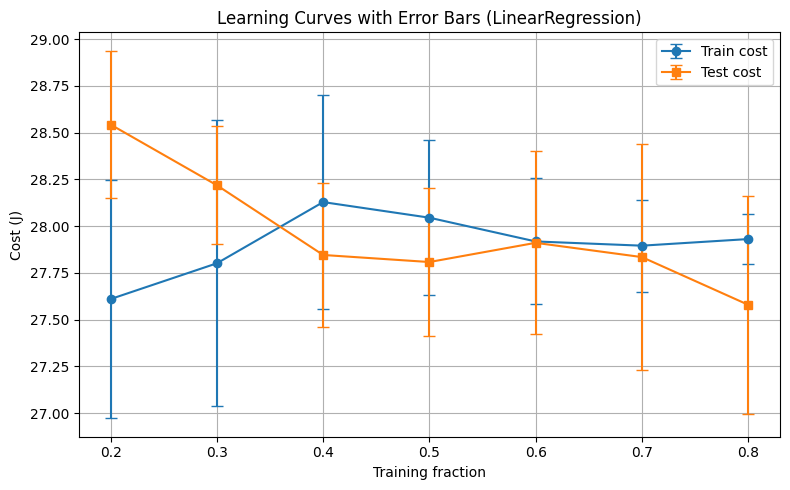

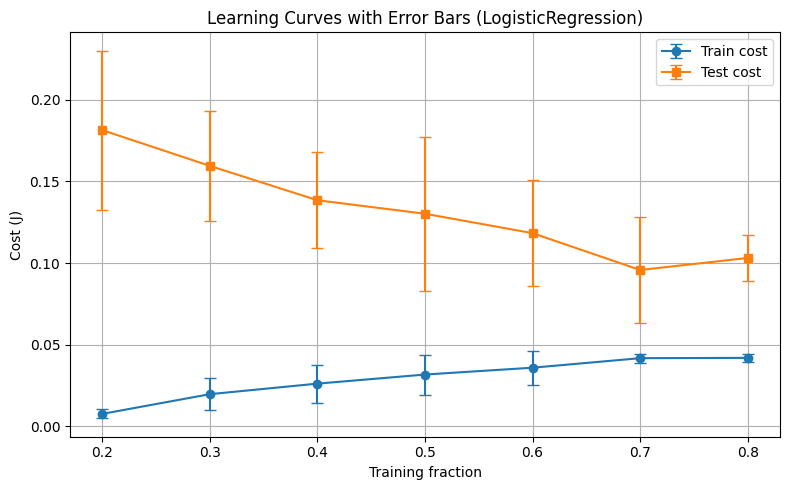

In [70]:
plot_train_data_size_vs_cost(X_clean_P, y_clean_P, model=LinearRegression(add_bias=True), n_runs=5)
plot_train_data_size_vs_cost(X_clean_B, y_clean_B, model=LogisticRegression(add_bias=True), n_runs=5)


#### Observations:
1. Linear Regression:

As more training data is fed into the models, the test cost decreases overall, indicating the performance of the model improves. In contrast, the training cost gradually increases, reflecting that fitting a larger dataset is slightly harder and more sensitive to variations in data.

Train cost error bars shrinks, the model’s performance on the training data becomes more consistent.

Test error bars increases a little, this suggests that as the training set grows, the variability of predictions on unseen data increases slightly.

2. Logistic Regression

Logistic Regression proudces a nice and clear curve of the cost behaviour.

The error bars are generally more stable across different training sizes. This stability is likely due to the inherent nature of logistic regression, which constrains outputs to probabilities, reducing the variance in predictions compared to linear regression.

Notebly, for linear regression, the best split fraction is 8:2 (train:test). as for logistic regression, 7:3 gives the lowest cost.

### Q4

For both linear and logistic regression, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried

In [71]:
def display_table_image(df, title):
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('off')
    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        cellLoc='center',
        rowLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    plt.title(title, fontsize=12, pad=10)
    plt.show()

In [72]:
def run_minibatch_sgd_experiment(X, y, model_used, add_bias=True, learning_rate=0.1):
  print(f"=====================Training {model_used} regression using minibatch SGD===================")
  batch_sizes = [8, 16, 32, 64, 128, X.shape[0]]
  x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
  )

  results = {}

  for batch in batch_sizes:

    model = Minibatch_SGD(add_bias=add_bias, model=model_used, learning_rate=learning_rate)
    theta, error_list = model.fit(
      X=x_train, y=y_train, batch_size=batch
    )
    final_cost = error_list[-1]
    convergence_iter = next(
      (i for i, c in enumerate(error_list) if abs(c - final_cost) < 1e-3),
      len(error_list)
    )


    results[batch] = {
      "final_cost": final_cost,
      "convergence_iter": convergence_iter
    }

    # Plot convergence curve
    plt.figure(figsize=(6,4))
    plt.plot(error_list)
    plt.xlabel("Number of iterations")
    plt.ylabel("Cost")
    plt.title(f"Convergence (batch={batch})")
    plt.show()

  summary_df = pd.DataFrame.from_dict(results, orient='index')
  summary_df.index.name = 'Batch Size'
  summary_df = summary_df.rename(index={summary_df.index[-1]: "full batch"})
  display_table_image(summary_df, f'Performance Summary ({model_used} Regression)')


=====================Training Linear regression using minibatch SGD===================


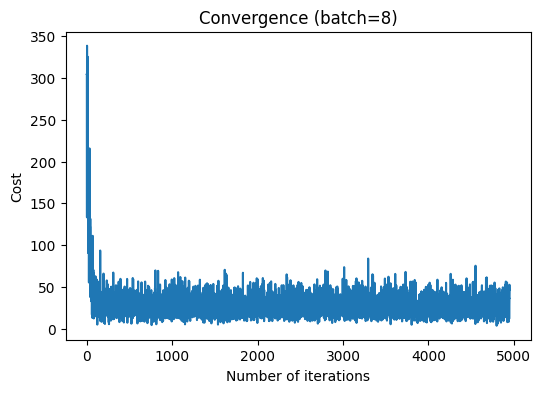

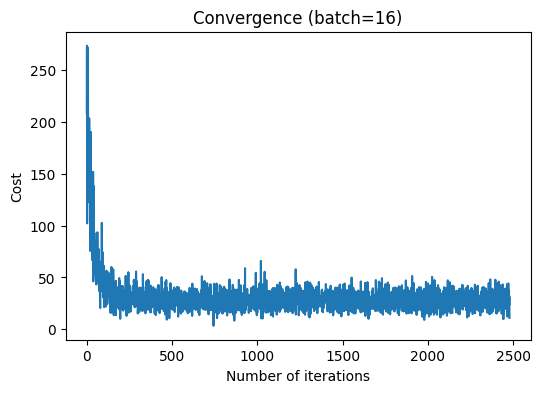

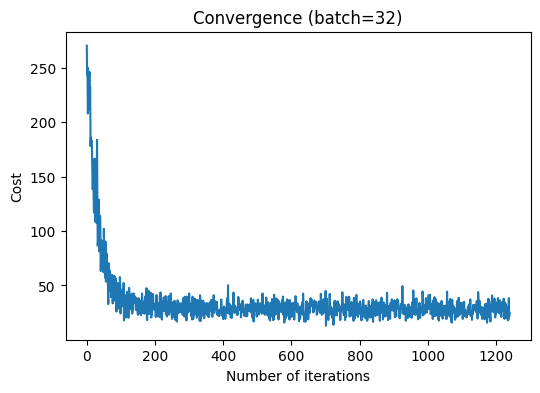

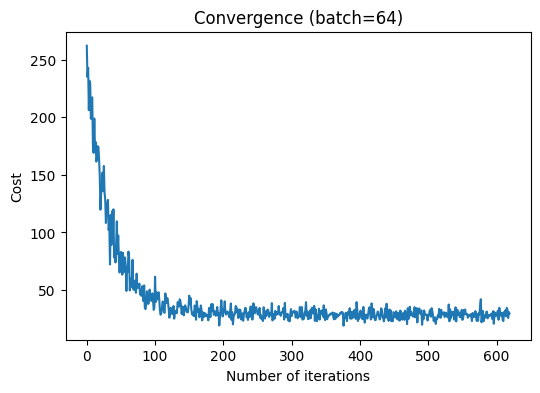

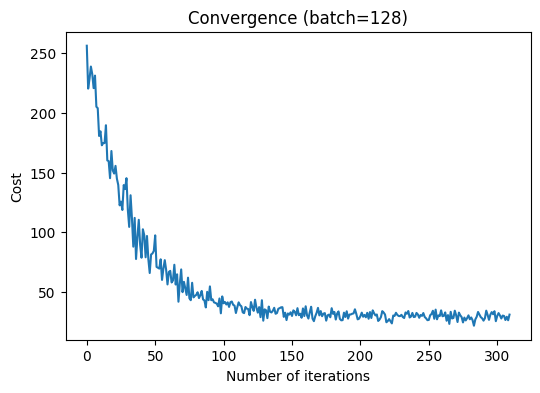

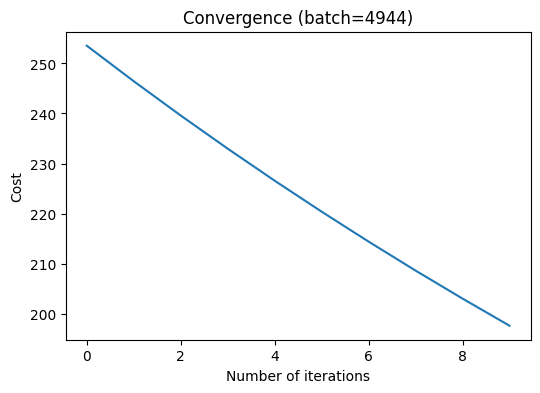

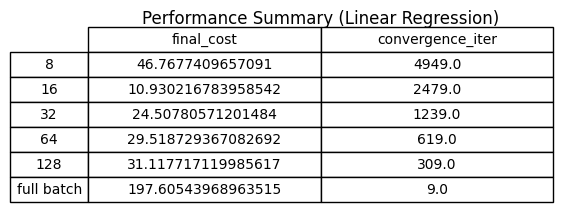

=====================Training Logistic regression using minibatch SGD===================


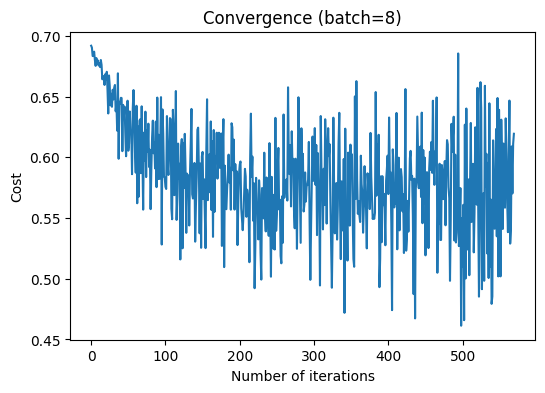

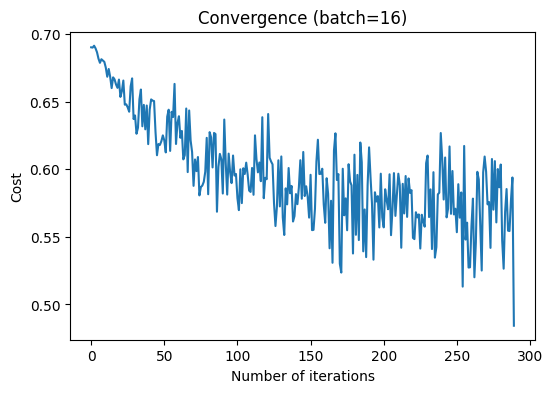

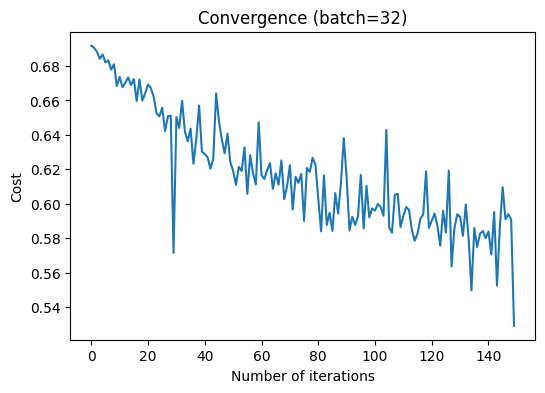

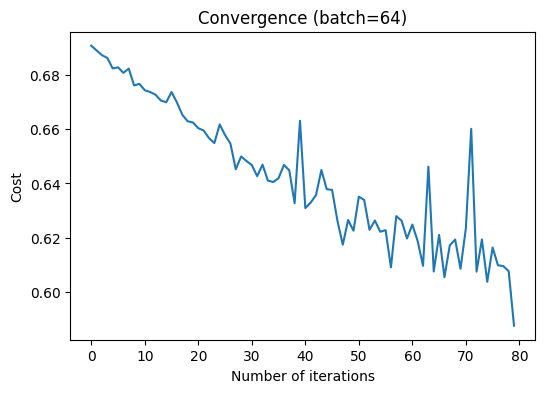

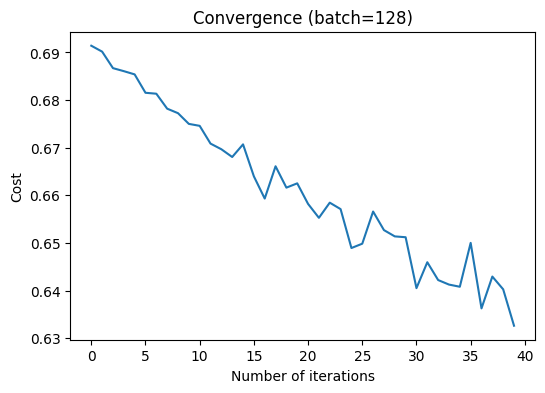

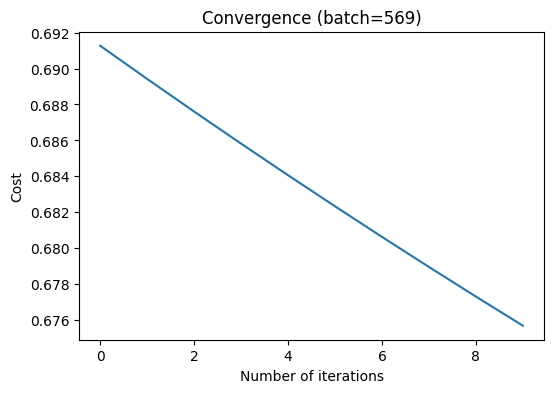

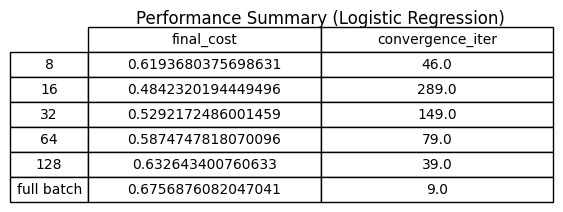

In [103]:
run_minibatch_sgd_experiment(X_clean_P, y_clean_P, model_used="Linear", learning_rate=0.01)
run_minibatch_sgd_experiment(X_clean_B, y_clean_B, model_used="Logistic", learning_rate=0.001)

##### Observations:
1. Linear Regression (& in general)

Larger batches provide a more accurate estimate of the gradient, which reduces the random fluctuations in the parameter updates. As a result, the learning curve becomes smoother and clearer, with smaller fluctuations in the cost. Additionally, since each update is more reliable, the model typically converges in fewer iterations compared to using smaller batch sizes.

2. Logistic Regression:

compare to the learning curve for Linear Regression, the curve flunctuates more as the gradient get closer to the optimized g. As training nears the optimum, the true gradient becomes very small while the random differences between mini-batches stay roughly the same. This makes the noise large compared to the signal, so the cost oscillates more.

3. Comparison

The final performance of using Minibatch SGD is overall better than the fully-batched baseline (by almost 2 times), but the performance for Logistic is worse.

**Best batch size is 32 for Linear Regression and 16 for Logistic regression**, since they produces lowest final cost

### Q5

Present the performance of both linear and logistic regression with at least three different learning rates (your own choice)

In [74]:
# Learning rates for the experiment

learning_rates_5 = [.001, .005, .01, .05, 0.1]

#### Linear regression

In [75]:
# Splitting the data - Parkison for linear regression (50%, 50% as stated on Q3)

X_train_tr_P_5, X_test_tr_P_5, y_train_tr_P_5, y_test_tr_P_5 = train_test_split(
    X_clean_P, y_clean_P, test_size=0.5, random_state=42
)

y_train_tr_P_5 = np.asarray(y_train_tr_P_5).ravel()
y_test_tr_P_5  = np.asarray(y_test_tr_P_5).ravel()

In [76]:
def costs_hist(w_hist, X, y, add_bias=True):
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1, 1)
    if X.ndim == 1:
        X = X[:, None]
    if add_bias:
        X = np.column_stack([X, np.ones((X.shape[0], 1))])
    costs = []
    for w in w_hist:
        w = np.asarray(w).reshape(-1, 1)
        err = X @ w - y
        costs.append(0.5 * np.mean(err**2))  # = 0.5*MSE
    return costs

In [77]:
# Reporting Linear regression

def report_linear_setname(y_true, y_pred, setname):
    print(f"=== {setname} ===")
    print("R2:", r2_score(y_true, y_pred))
    print("MSE:", mean_squared_error(y_true, y_pred))


def report_linear_reg(learning_rate):
  optimizer = GradientDescent(learning_rate=learning_rate, max_iters=5000, record_history=True)
  model = LinearRegressionOptimizer()
  model.fit(X_train_tr_P_5, y_train_tr_P_5, optimizer)
  y_pred_test = model.predict(X_test_tr_P_5)
  y_pred_train = model.predict(X_train_tr_P_5)

  y_tr_pred = y_pred_train.reshape(-1)
  y_te_pred = y_pred_test.reshape(-1)
  y_tr = np.asarray(y_train_tr_P_5).reshape(-1)
  y_te = np.asarray(y_test_tr_P_5).reshape(-1)


  res = {
            "train_r2": r2_score(y_tr, y_tr_pred),
            "train_mse": mean_squared_error(y_tr, y_tr_pred),
            "test_r2": r2_score(y_te, y_te_pred),
            "test_mse": mean_squared_error(y_te, y_te_pred),
            "costs": costs_hist(optimizer.w_history, X_train_tr_P_5, y_train_tr_P_5, add_bias=True)
        }

  print("=============================")
  print("Learning rate: ",learning_rate)
  report_linear_setname(y_train_tr_P_5, model.predict(X_train_tr_P_5), "Train")
  report_linear_setname(y_test_tr_P_5, y_pred_test, "Test")
  print("=============================\n")

  return res

In [78]:
results = {}
for i, lr in enumerate(learning_rates_5):
  results[lr] = report_linear_reg(lr)

Learning rate:  0.001
=== Train ===
R2: 0.1277224182676533
MSE: 59.190579475116515
=== Test ===
R2: 0.11497048458581238
MSE: 58.59112287904132

Learning rate:  0.005
=== Train ===
R2: 0.17314629255438763
MSE: 56.10822874486279
=== Test ===
R2: 0.15364081381305894
MSE: 56.03105231408819

Learning rate:  0.01
=== Train ===
R2: 0.17667162225388666
MSE: 55.86900867074399
=== Test ===
R2: 0.15521356708640155
MSE: 55.92693219301663

Learning rate:  0.05
=== Train ===
R2: 0.17922672322286437
MSE: 55.695625896569204
=== Test ===
R2: 0.1545783420093476
MSE: 55.96898564987575

Learning rate:  0.1
=== Train ===
R2: 0.1795356808605414
MSE: 55.67466080244052
=== Test ===
R2: 0.15416522479905403
MSE: 55.99633502163137



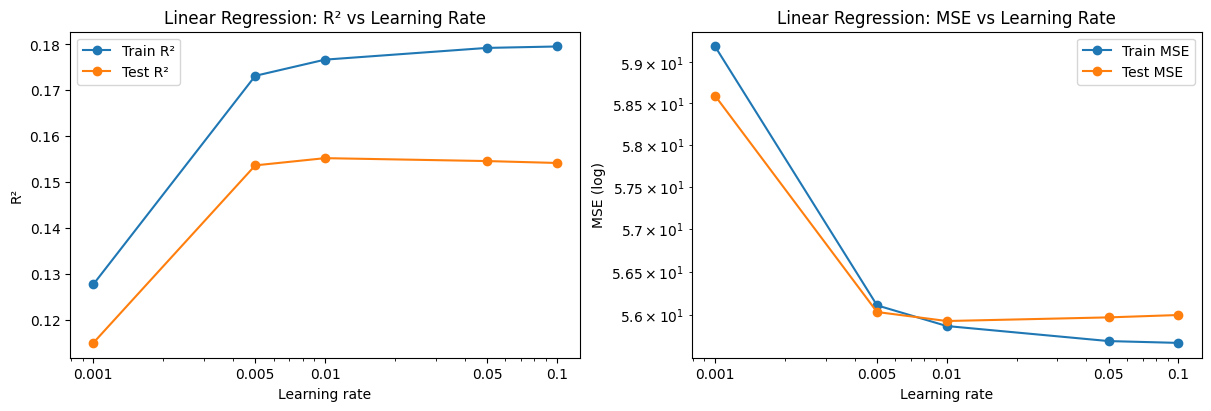

In [79]:
lrs = list(results.keys())
lrs_sorted = sorted(lrs)
x = range(len(lrs))

train_r2s = [results[lr]["train_r2"] for lr in lrs]
test_r2s  = [results[lr]["test_r2"]  for lr in lrs]

train_mse = [results[lr]["train_mse"] for lr in lrs]
test_mse  = [results[lr]["test_mse"]  for lr in lrs]

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, constrained_layout=True)

axes[0].plot(lrs, train_r2s, marker="o", label="Train R²")
axes[0].plot(lrs, test_r2s,  marker="o", label="Test R²")
axes[0].set_xscale("log")
axes[0].set_xlabel("Learning rate")
axes[0].set_ylabel("R²")
axes[0].set_title("Linear Regression: R² vs Learning Rate")
axes[0].legend()

axes[1].plot(lrs, train_mse, marker="o", label="Train MSE")
axes[1].plot(lrs, test_mse,  marker="o", label="Test MSE")
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("Learning rate")
axes[1].set_ylabel("MSE (log)")
axes[1].set_title("Linear Regression: MSE vs Learning Rate")
axes[1].legend()

for ax in axes:
    ax.set_xticks(lrs_sorted)
    ax.set_xticklabels([f"{lr:g}" for lr in lrs_sorted])

plt.show()

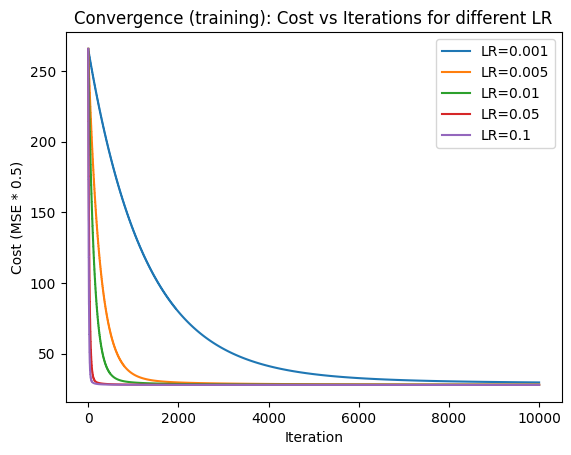

In [80]:
plt.figure()
for lr in lrs:
    plt.plot(results[lr]["costs"], label=f"LR={lr}")
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE * 0.5)")
plt.title("Convergence (training): Cost vs Iterations for different LR")
plt.legend()
plt.show()

##### Observations

For linear regression, all learning rates above 0.005 displayed subtle changes and converged to similar MSEs and R² values. In addition, the higher the learning rate, the faster the convergence. 0.01 is a good trade-off between speed to converge and stability for MSE and R².


#### Logistic regression

In [81]:
# Splitting the data - Breast cancer for logistic regression (50%, 50% as stated on Q3)

X_train_B_5, X_test_B_5, y_train_B_5, y_test_B_5 = train_test_split(
    X_clean_B, y_clean_B, test_size=0.5, random_state=42, stratify=y_clean_B
)

In [82]:
# Reporting logistic regression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def report_logistic_metrics(y_true, y_pred, y_prob, setname):
    print(f"=== {setname} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print()


def report_logistic_reg(learning_rate):
  model = LogisticRegression(add_bias=True, learning_rate=learning_rate, epsilon=1e-6, max_iters=10000, verbose=False)
  model.fit(X_train_B_5, y_train_B_5)

  # Predictions
  y_train_pred_prob = model.predict(X_train_B_5)
  y_test_pred_prob = model.predict(X_test_B_5)

  # Convert probabilities to labels
  y_train_pred = (y_train_pred_prob >= 0.5).astype(int)
  y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

  print("=============================")
  print(f"Learning rate: {learning_rate}")
  report_logistic_metrics(y_train_B_5, y_train_pred, y_train_pred_prob, "Train")
  report_logistic_metrics(y_test_B_5, y_test_pred, y_test_pred_prob, "Test")
  print("=============================\n")

  res = 0

  res = {
      "train_accuracy": accuracy_score(y_train_B_5, y_train_pred),
      "train_f1": f1_score(y_train_B_5, y_train_pred),

      "test_accuracy": accuracy_score(y_test_B_5, y_test_pred),
      "test_f1": f1_score(y_test_B_5, y_test_pred),
  }

  return res

In [83]:
results = {}
for i, lr in enumerate(learning_rates_5):
  results[lr] = report_logistic_reg(lr)

Learning rate: 0.001
=== Train ===
Accuracy : 0.9753521126760564
Precision: 0.9805825242718447
Recall   : 0.9528301886792453
F1 Score : 0.9665071770334929
Confusion matrix:
 [[176   2]
 [  5 101]]

=== Test ===
Accuracy : 0.9859649122807017
Precision: 0.9903846153846154
Recall   : 0.9716981132075472
F1 Score : 0.9809523809523809
Confusion matrix:
 [[178   1]
 [  3 103]]


Learning rate: 0.005
=== Train ===
Accuracy : 0.9823943661971831
Precision: 0.9902912621359223
Recall   : 0.9622641509433962
F1 Score : 0.9760765550239234
Confusion matrix:
 [[177   1]
 [  4 102]]

=== Test ===
Accuracy : 0.9824561403508771
Precision: 1.0
Recall   : 0.9528301886792453
F1 Score : 0.9758454106280193
Confusion matrix:
 [[179   0]
 [  5 101]]


Learning rate: 0.01
=== Train ===
Accuracy : 0.9894366197183099
Precision: 1.0
Recall   : 0.9716981132075472
F1 Score : 0.9856459330143541
Confusion matrix:
 [[178   0]
 [  3 103]]

=== Test ===
Accuracy : 0.9789473684210527
Precision: 0.9901960784313726
Recall   :

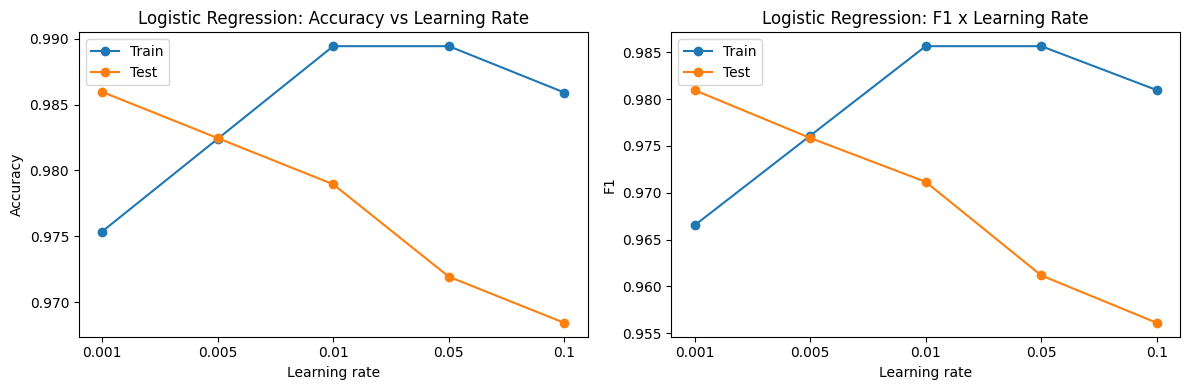

In [84]:
lrs = sorted(results.keys())

acc_tr = [results[lr]['train_accuracy'] for lr in lrs]
acc_te = [results[lr]['test_accuracy']  for lr in lrs]
f1_tr  = [results[lr]['train_f1']       for lr in lrs]
f1_te  = [results[lr]['test_f1']        for lr in lrs]

x = range(len(lrs))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

axes[0].set_title('Logistic Regression: Accuracy vs Learning Rate')
axes[0].plot(x, acc_tr, marker='o', label='Train')
axes[0].plot(x, acc_te, marker='o', label='Test')
axes[0].set_xticks(x, [str(lr) for lr in lrs])
axes[0].set_xlabel('Learning rate');
axes[0].set_ylabel('Accuracy')
axes[0].legend();


axes[1].set_title('Logistic Regression: F1 x Learning Rate')
axes[1].plot(x, f1_tr, marker='o', label='Train')
axes[1].plot(x, f1_te, marker='o', label='Test')
axes[1].set_xticks(x, [str(lr) for lr in lrs])
axes[1].set_xlabel('Learning rate');
axes[1].set_ylabel('F1')
axes[1].legend();

plt.tight_layout()
plt.show()

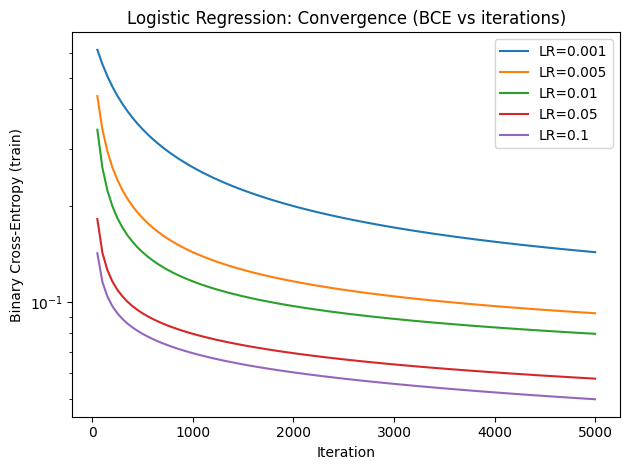

In [85]:
def convergence_curve_with_refits(Xtr, ytr, lr, K=5000, step=50):
    steps = np.arange(step, K+1, step)
    losses = []
    for k in steps:
        m = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=0.0, max_iters=k, verbose=False)
        m.fit(Xtr, ytr)                         # assumed deterministic init
        p_tr = np.asarray(m.predict(Xtr)).reshape(-1)
        losses.append(log_loss(ytr, p_tr, labels=[0,1]))
    return steps, losses

plt.figure()
for lr in learning_rates_5:
    steps, losses = convergence_curve_with_refits(X_train_B_5, y_train_B_5, lr, K=5000, step=50)
    plt.plot(steps, losses, label=f"LR={lr}")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy (train)")
plt.title("Logistic Regression: Convergence (BCE vs iterations)")
plt.legend(); plt.tight_layout(); plt.show()


### Q6

Compare analytical linear regression solution with mini-batch stochastic gradient descent based linear regression solution. What do you find?

In [86]:
# Splitting the data

X_train_tr_P_6, X_test_tr_P_6, y_train_tr_P_6, y_test_tr_P_6 = train_test_split(
    X_clean_P, y_clean_P, test_size=0.5, random_state=42
)

In [87]:
# Analytical Linear Regression

analytical_linear_regression_6 = LinearRegression(add_bias=True).fit(X_train_tr_P_6, y_train_tr_P_6)
y_train_pred_6 = analytical_linear_regression_6.predict(X_train_tr_P_6)
y_test_pred_6 = analytical_linear_regression_6.predict(X_test_tr_P_6)

In [88]:
# Reporting

print(f"=== Train ===")
print("R2:", r2_score(y_train_tr_P_6, y_train_pred_6))
print("MSE:", mean_squared_error(y_train_tr_P_6, y_train_pred_6))

print(f"=== Test ===")
print("R2:", r2_score(y_test_tr_P_6, y_test_pred_6))
print("MSE:", mean_squared_error(y_test_tr_P_6, y_test_pred_6))

=== Train ===
R2: 0.17979976572154777
MSE: 55.6567406629334
=== Test ===
R2: 0.15363635866907666
MSE: 56.03134725553813


In [89]:
# Mini-batch Stochastic Gradient descent based Linear Regression
# Batch size is 32. According to experiment 4, it is the best for linear regression.

model = Minibatch_SGD(add_bias=True, model="Linear", learning_rate=0.005)
theta, error_list = model.fit(
  X=X_train_tr_P_6, y=y_train_tr_P_6, batch_size=32
)

# 2) Manually adding bias (because of the implementation, it is needed) and predicting
Xtr_b = np.hstack([np.asarray(X_train_tr_P_6), np.ones((len(X_train_tr_P_6), 1))])
Xte_b = np.hstack([np.asarray(X_test_tr_P_6),  np.ones((len(X_test_tr_P_6),  1))])
yhat_tr = model.predict(Xtr_b, theta).reshape(-1)
yhat_te = model.predict(Xte_b, theta).reshape(-1)

# 4) y as 1-D
ytr = np.asarray(y_train_tr_P_6).reshape(-1)
yte = np.asarray(y_test_tr_P_6).reshape(-1)


In [90]:
# Reporting
print(f"=== Train ===")
print("R2:", r2_score(ytr, yhat_tr))
print("MSE:", mean_squared_error(ytr, yhat_tr))

print(f"=== Test ===")
print("R2:", r2_score(yte, yhat_te))
print("MSE:", mean_squared_error(yte, yhat_te))

=== Train ===
R2: 0.15156463723537195
MSE: 57.57270600659385
=== Test ===
R2: 0.13521905721209337
MSE: 57.250617747620474


In [91]:
J_analytical_train = 0.5 * np.mean((ytr - y_train_pred_6.reshape(-1))**2)
J_mb_train = 0.5 * np.mean((ytr - yhat_tr)**2)

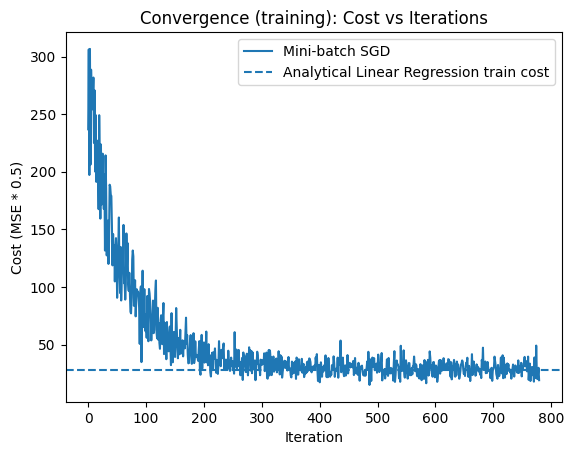

In [92]:
plt.figure()
plt.plot(error_list, label="Mini-batch SGD")
plt.axhline(J_analytical_train, linestyle="--", label="Analytical Linear Regression train cost")
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE * 0.5)")
plt.title("Convergence (training): Cost vs Iterations")
plt.legend()
plt.show()

### EXTRA: Non-linear improvement

In this experiment we expanded the numeric features using non-linear basis functions (Gaussian and Sigmoid) with different numbers of basis functions (D = 10, 20, 35). After transforming and scaling these expanded features, we combined them with the binary (OHE) features and trained a custom linear regression model.

Results:
The Gaussian basis with D=35 performed best, comparing to smaller Gaussian expansions and all sigmoid variants.

=== Test metrics by basis ===
               MSE    RMSE     MAE      R2
gauss_D35  19.7708  4.4464  3.4068  0.6948
gauss_D20  28.3924  5.3285  4.1673  0.5617
sigm_D35   21.9963  4.6900  3.4680  0.6605
sigm_D20   21.9248  4.6824  3.6496  0.6616
sigm_D10   38.2973  6.1885  5.0672  0.4088

=== Best configuration ===
gauss_D35 | {'MSE': 19.7708, 'RMSE': 4.4464, 'MAE': 3.4068, 'R2': 0.6948}


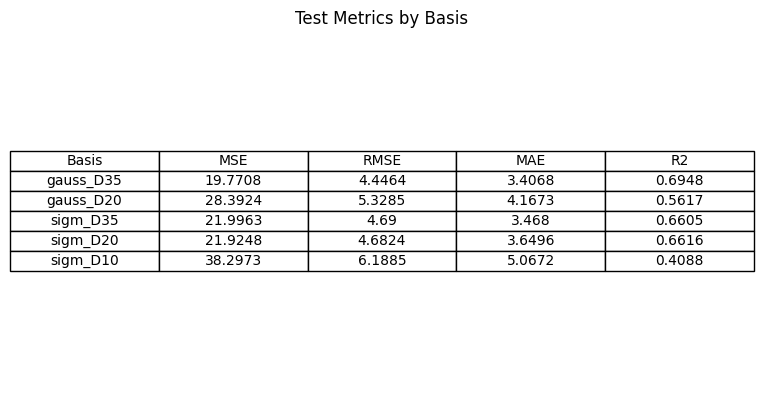

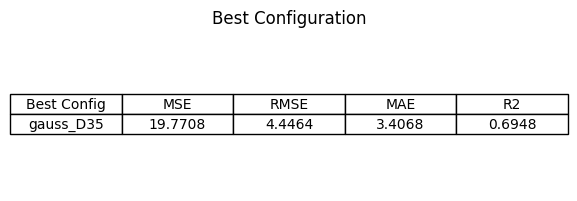

In [93]:

X_train_tr_P_gauss, X_test_tr_P_gauss, y_train_tr_P_gauss, y_test_tr_P_gauss = train_test_split(
      X_clean_P, y_clean_P, test_size=0.20, random_state=42
)
bases = {
    "gauss_D35": ("gauss", 35),
    "gauss_D20": ("gauss", 20),
    "sigm_D35":   ("sigm", 35),
    "sigm_D20": ("sigm", 20),
    "sigm_D10":  ("sigm", 10),

}
def split_num_ohe(X, numeric_cols):
    import numpy as np, pandas as pd
    if isinstance(X, pd.DataFrame):
        X_num = X[numeric_cols].to_numpy()
        X_ohe = X.drop(columns=numeric_cols).to_numpy()
    else:
        n_num = len(numeric_cols)
        X_num = X[:, :n_num]
        X_ohe = X[:, n_num:]
    return X_num, X_ohe

Xtr_num, Xtr_ohe = split_num_ohe(X_train_tr_P_gauss, numeric_cols_P)
Xte_num, Xte_ohe = split_num_ohe(X_test_tr_P_gauss,  numeric_cols_P)

results = []
best = {"name": None, "metrics": None, "y_pred": None}
preds = {}

for name, (kind, D) in bases.items():
    if kind == "gauss":
        mus, sig = gaussian_basis_fit(Xtr_num, D=D, sigma='auto')
        Phi_tr = gaussian_basis_transform(Xtr_num, mus, sig)
        Phi_te = gaussian_basis_transform(Xte_num, mus, sig)
        basis_params = (mus, sig)
    else:  # "sigm"
        mus, sc = sigmoid_basis_fit(Xtr_num, D=D, s='auto')
        Phi_tr = sigmoid_basis_transform(Xtr_num, mus, sc)
        Phi_te = sigmoid_basis_transform(Xte_num, mus, sc)
        basis_params = (mus, sc)

    scaler_phi = StandardScaler().fit(Phi_tr)
    Phi_tr_s = scaler_phi.transform(Phi_tr)
    Phi_te_s = scaler_phi.transform(Phi_te)

    Xtr_final = np.hstack([Phi_tr_s, Xtr_ohe])
    Xte_final = np.hstack([Phi_te_s, Xte_ohe])

    mdl_gaus = LinearRegression(add_bias=True).fit(Xtr_final, y_train_tr_P_gauss)
    y_pred = mdl_gaus.predict(Xte_final)
    metrics = eval_metrics(y_test_tr_P_gauss, y_pred)

    results.append((name, metrics))
    preds[name] = y_pred

    if best["metrics"] is None or metrics["MSE"] < best["metrics"]["MSE"]:
        best.update({
            "name": name,
            "metrics": metrics,
            "y_pred": y_pred,
            "Xtr_final": Xtr_final,
            "Xte_final": Xte_final,
            "scaler_phi": scaler_phi,
            "basis_kind": kind,
            "basis_D": D,
            "basis_params": basis_params,
            "model": mdl_gaus,
        })

print("=== Test metrics by basis ===")
df_res = pd.DataFrame({n: m for n, m in results}).T.round(4)[["MSE","RMSE","MAE","R2"]]
print(df_res)

print("\n=== Best configuration ===")
print(best["name"], "|", {k: round(v, 4) for k, v in best["metrics"].items()})

df_res = pd.DataFrame({n: m for n, m in results}).T.round(4)[["MSE","RMSE","MAE","R2"]]

fig, ax = plt.subplots(figsize=(8, len(df_res)*0.5 + 2))
ax.axis("off")

table = ax.table(
    cellText=df_res.reset_index().values,
    colLabels=["Basis"] + df_res.columns.tolist(),
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Test Metrics by Basis", fontsize=12, pad=10)
plt.show()

best_metrics = {k: round(v, 4) for k, v in best["metrics"].items()}
best_df = pd.DataFrame([best_metrics], index=[best["name"]])

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis("off")

table = ax.table(
    cellText=best_df.reset_index().values,
    colLabels=["Best Config"] + best_df.columns.tolist(),
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("Best Configuration", fontsize=12, pad=10)
plt.show()



=== Best model metrics ===
{'MSE': 19.770757347572694, 'RMSE': 4.446431979415933, 'MAE': 3.406838589873199, 'R2': 0.6948071816158761}


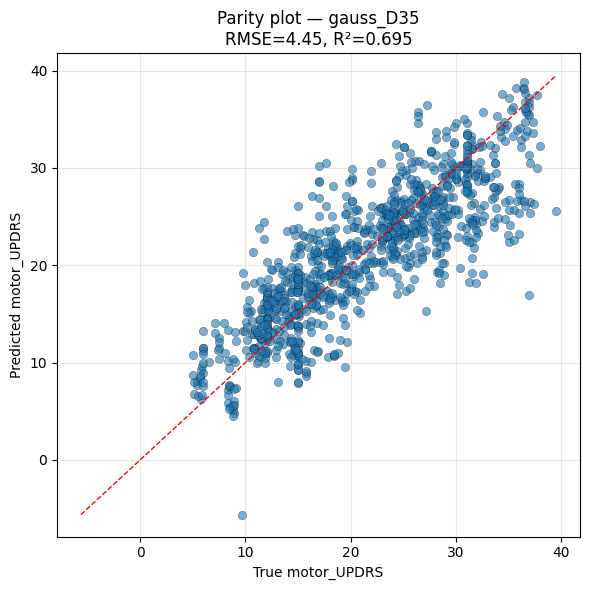

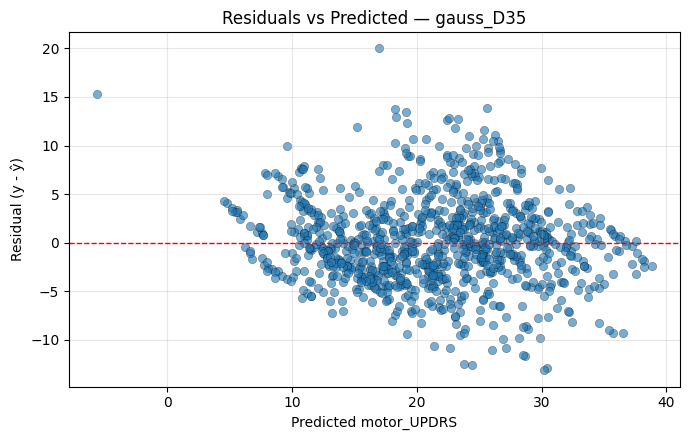

In [94]:
X_train_best_df = pd.DataFrame(
    best["Xtr_final"],
    index=X_train_tr_P_gauss.index,
    columns=[f"basis_{i}" for i in range(best["Xtr_final"].shape[1])]
)

X_test_best_df = pd.DataFrame(
    best["Xte_final"],
    index=X_test_tr_P_gauss.index,
    columns=[f"basis_{i}" for i in range(best["Xte_final"].shape[1])]
)

y_train_best_df = pd.DataFrame(y_train_tr_P_gauss, index=X_train_tr_P_gauss.index, columns=["motor_UPDRS"])
y_test_best_df  = pd.DataFrame(y_test_tr_P_gauss,  index=X_test_tr_P_gauss.index,  columns=["motor_UPDRS"])


mdl_best = LinearRegression(add_bias=True).fit(
    X_train_best_df.values, y_train_best_df.values.ravel()
)
y_pred_best = mdl_best.predict(X_test_best_df.values)


metrics_best = eval_metrics(y_test_best_df.values.ravel(), y_pred_best)
print("=== Best model metrics ===")
print(metrics_best)

plt.figure(figsize=(6,6))
y_true = y_test_best_df.values.ravel()

plt.scatter(y_true, y_pred_best, alpha=0.6, edgecolor="k", linewidth=0.3)
lims = [min(y_true.min(), y_pred_best.min()), max(y_true.max(), y_pred_best.max())]
plt.plot(lims, lims, "r--", linewidth=1)
plt.xlabel("True motor_UPDRS")
plt.ylabel("Predicted motor_UPDRS")
plt.title(f"Parity plot — {best['name']}\nRMSE={metrics_best['RMSE']:.2f}, R²={metrics_best['R2']:.3f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

resid = y_true - y_pred_best
plt.figure(figsize=(7,4.5))
plt.scatter(y_pred_best, resid, alpha=0.6, edgecolor="k", linewidth=0.3)
plt.axhline(0, color="r", linestyle="--", linewidth=1)
plt.xlabel("Predicted motor_UPDRS")
plt.ylabel("Residual (y - ŷ)")
plt.title(f"Residuals vs Predicted — {best['name']}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### EXTRA: Gradient Descent with momentum

In [95]:
# Splitting the data


X_train_tr_P_momentum, X_test_tr_P_momentum, y_train_tr_P_momentum, y_test_tr_P_momentum = train_test_split(
    X_clean_P, y_clean_P, test_size=0.5, random_state=42
)

y_train_tr_P_momentum = np.asarray(y_train_tr_P_momentum).ravel()
y_test_tr_P_momentum  = np.asarray(y_test_tr_P_momentum).ravel()

In [96]:
class GradientDescentMomentum:
    def __init__(self, learning_rate=0.01, max_iters=10000, epsilon=1e-8, momentum=0.9, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = int(max_iters)
        self.epsilon = epsilon
        self.momentum = momentum
        self.record_history = record_history
        if record_history:
            self.w_history = []

    def run(self, gradient_fn, x, y, w_init):
        w = np.array(w_init, dtype=float)
        v = np.zeros_like(w) # Velocity
        grad = np.inf
        t = 0

        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            v = self.momentum * v + self.learning_rate * grad # Momentum update
            w = w - v
            if self.record_history:
                self.w_history.append(w.copy())

            t += 1

        return w

In [97]:
# Linear regression with gradient descent without momentum

optimizer_no_momentum = GradientDescent(learning_rate=.01, max_iters=5000, record_history=True)
model_no_momentum = LinearRegressionOptimizer()
model_no_momentum.fit(X_train_tr_P_momentum, y_train_tr_P_momentum, optimizer_no_momentum)
y_pred_no_momentum_train = model_no_momentum.predict(X_train_tr_P_5)
y_pred_no_momentum_test = model_no_momentum.predict(X_test_tr_P_5)


print(f"=== Train ===")
print("R2:", r2_score(y_train_tr_P_momentum, y_pred_no_momentum_train))
print("MSE:", mean_squared_error(y_train_tr_P_momentum, y_pred_no_momentum_train))
print(f"=== Test ===")
print("R2:", r2_score(y_test_tr_P_momentum, y_pred_no_momentum_test))
print("MSE:", mean_squared_error(y_test_tr_P_momentum, y_pred_no_momentum_test))


=== Train ===
R2: 0.17667162225388666
MSE: 55.86900867074399
=== Test ===
R2: 0.15521356708640155
MSE: 55.92693219301663


In [98]:
# Linear regression with gradient descent without momentum

optimizer_momentum = GradientDescentMomentum(learning_rate=.01, max_iters=5000, momentum=0.9, record_history=True)
model_momentum = LinearRegressionOptimizer()
model_momentum.fit(X_train_tr_P_momentum, y_train_tr_P_momentum, optimizer_momentum)
y_pred_momentum_train = model_momentum.predict(X_train_tr_P_momentum)
y_pred_momentum_test = model_momentum.predict(X_test_tr_P_momentum)

print(f"=== Train ===")
print("R2:", r2_score(y_train_tr_P_momentum, y_pred_momentum_train))
print("MSE:", mean_squared_error(y_train_tr_P_momentum, y_pred_momentum_train))
print(f"=== Test ===")
print("R2:", r2_score(y_test_tr_P_momentum, y_pred_momentum_test))
print("MSE:", mean_squared_error(y_test_tr_P_momentum, y_pred_momentum_test))

=== Train ===
R2: 0.17953582501565113
MSE: 55.67465102043459
=== Test ===
R2: 0.15416422680857966
MSE: 55.99640109104657


In [99]:
# Reshaping to plot
y_tr_pred_gd   = y_pred_no_momentum_train.reshape(-1)
y_te_pred_gd   = y_pred_no_momentum_test.reshape(-1)

y_tr_pred_mom  = y_pred_momentum_train.reshape(-1)
y_te_pred_mom  = y_pred_momentum_test.reshape(-1)

y_tr = np.asarray(y_train_tr_P_momentum).reshape(-1)
y_te = np.asarray(y_test_tr_P_5).reshape(-1)


In [100]:
# Utilitary functions

def add_bias(X):
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, None]
    return np.column_stack([X, np.ones(X.shape[0])])

def cost_from_w_hist(w_hist):
    return [0.5*np.mean((Xtr_b @ w.reshape(-1,1) - ytr_c)**2) for w in w_hist]

Xtr_b = add_bias(X_train_tr_P_momentum)
ytr_c = y_tr.reshape(-1, 1)



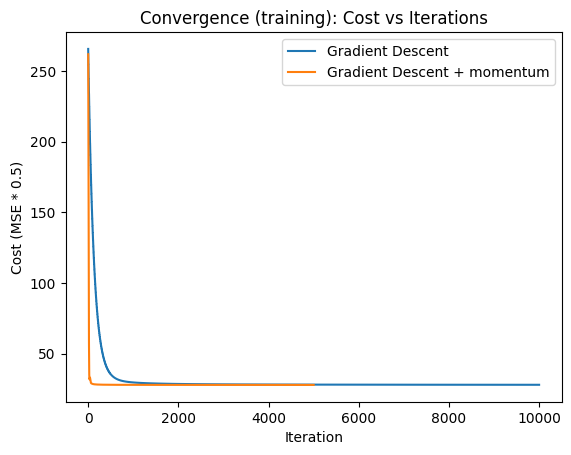

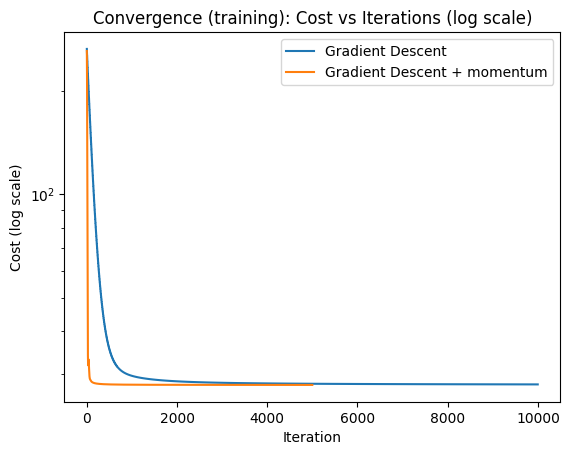

In [101]:
costs_gd  = cost_from_w_hist(optimizer_no_momentum.w_history)
costs_mom = cost_from_w_hist(optimizer_momentum.w_history)


plt.figure()
plt.plot(costs_gd,  label="Gradient Descent")
plt.plot(costs_mom, label="Gradient Descent + momentum")
plt.xlabel("Iteration")
plt.ylabel("Cost (MSE * 0.5)")
plt.title("Convergence (training): Cost vs Iterations")
plt.legend()
plt.show()

plt.figure()
plt.plot(costs_gd,  label="Gradient Descent")
plt.plot(costs_mom, label="Gradient Descent + momentum")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Cost (log scale)")
plt.title("Convergence (training): Cost vs Iterations (log scale)")
plt.legend()
plt.show()

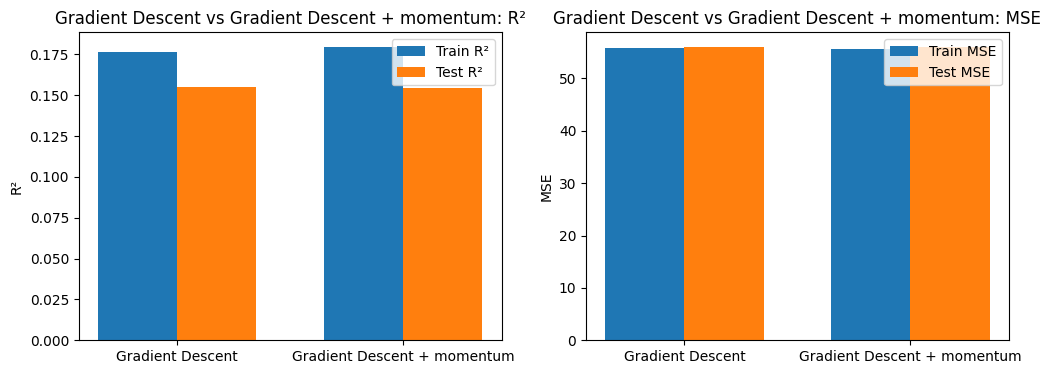

In [102]:
methods = ["Gradient Descent", "Gradient Descent + momentum"]
train_r2s = [r2_score(y_tr, y_tr_pred_gd),  r2_score(y_tr, y_tr_pred_mom)]
test_r2s  = [r2_score(y_te, y_te_pred_gd),  r2_score(y_te, y_te_pred_mom)]
train_mse = [mean_squared_error(y_tr, y_tr_pred_gd), mean_squared_error(y_tr, y_tr_pred_mom)]
test_mse  = [mean_squared_error(y_te, y_te_pred_gd), mean_squared_error(y_te, y_te_pred_mom)]
x = np.arange(len(methods)); w = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# R2
axes[0].bar(x - w/2, train_r2s, w, label="Train R²")
axes[0].bar(x + w/2, test_r2s,  w, label="Test R²")
axes[0].set_xticks(x, methods)
axes[0].set_ylabel("R²")
axes[0].set_title("Gradient Descent vs Gradient Descent + momentum: R²")
axes[0].legend()

# MSE
axes[1].bar(x - w/2, train_mse, w, label="Train MSE")
axes[1].bar(x + w/2, test_mse,  w, label="Test MSE")
axes[1].set_xticks(x, methods)
axes[1].set_ylabel("MSE")
axes[1].set_title("Gradient Descent vs Gradient Descent + momentum: MSE")
axes[1].legend()
